In [1]:
import pylab as pl
from glob import glob
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

import csv
import os
import datetime
import pandas as pd
import shapefile as shp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import netCDF4 as nc4
from datetime import date,timedelta
import plotly.graph_objs as go
import matplotlib.lines as mlines
import seaborn as sns
import shapely as shp
from shapely.geometry import Point
from geopandas.tools import sjoin
import importlib
import geopandas as gpd
from matplotlib.patches import Rectangle
from collections import Counter
import time
import _pickle as pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
#import external functions (need pip install ipynb)
import ipynb.fs.full.HaileventsFunctions as HF

# 4) VALIDATION OF OT-HAIL PROXY WITH ESWD HAIL REPORTS

## Notebook for validating the filtered and unfiltered datasets vs hail reports

- Upload OT data (**5-95%** thresholds filt) and hail reports data
- sea-land mask filter for OT data: retain only land OT detection (which can be verified against observations!)
- Define spatial and temporal window to check the matching between the two datasets:
    - spatial window: consider **25km** like in Punge 2017
    - for ESWD: temporal window **+-1.5h** (in Punge 2017 they used 1h but since I introduced temporal uncertainty aggregating all OTs to 1 hour it is better to consider 1.5h)
- The length of the HITTED/HITTING datasets of reports/OTs respectively is the same and can be much longer than the respective unique datasets (without repetitions) because there could be more than one OT hitting the same observation as well as more than one observation hitted by the same OT -> this is why we need to clean datasets from repetitions before usage!
- Build contingency tables and compute scores

## 4.0) - Preamble: load data folder, shapefiles, lat-lon domain, load ESWD reports, define days of interest, load OT filt-unfilt data

In [2]:
#Define preliminar parameters: files folder, shapefiles, lat-lon domain
fold, sf_geo, sfg_land, sf_sp, lonmin, lonmax, latmin, latmax, x_lim, y_lim, hhmin, hhmax = HF.HF_preamble()

#### - Load ESWD data

In [3]:
#Read ESWD data:
df_eswd_1 = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_19790101-20200531_v1_6.csv')
df_eswd_2 = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_20200601-20201031_v1_6.csv')

#Select data of interest
eswd_df_1 = pd.DataFrame()
eswd_df_1['datetime'] = pd.to_datetime(df_eswd_1['TIME_EVENT'])
eswd_df_1[['lat','lon','size','QC_level','Time_accuracy','Max_hailst_weight','Thickness_hail_layer','Total_damage',
          'N_injured','N_killed','Impacts']] = df_eswd_1[['LATITUDE','LONGITUDE','MAX_HAIL_DIAMETER','QC_LEVEL',
                                                          'TIME_ACCURACY','MAX_HAILSTONE_WEIGHT',
                                                          'THICKNESS_HAIL_LAYER','TOTAL_DAMAGE','NO_INJURED',
                                                         'NO_KILLED','IMPACTS']]
eswd_df_1 = eswd_df_1.sort_values(by='datetime').reset_index(drop=True)

#remove June 2020 data because they are already present in df_eswd_2
eswd_df_1 = eswd_df_1.drop(eswd_df_1[(eswd_df_1.datetime.dt.year==2020)&(eswd_df_1.datetime.dt.month==6)].index)

eswd_df_2 = pd.DataFrame()
eswd_df_2['datetime'] = pd.to_datetime(df_eswd_2['TIME_EVENT'])
eswd_df_2[['lat','lon','size','QC_level','Time_accuracy','Max_hailst_weight','Thickness_hail_layer','Total_damage',
          'N_injured','N_killed','Impacts']] = df_eswd_2[['LATITUDE','LONGITUDE','MAX_HAIL_DIAMETER','QC_LEVEL',
                                                          'TIME_ACCURACY','MAX_HAILSTONE_WEIGHT',
                                                          'THICKNESS_HAIL_LAYER','TOTAL_DAMAGE','NO_INJURED',
                                                         'NO_KILLED','IMPACTS']]
eswd_df_2 = eswd_df_2.sort_values(by='datetime').reset_index(drop=True)

#concat the two datasets:
eswd_df = pd.concat([eswd_df_1,eswd_df_2])

#Retain only reports in the selected period and space domain
eswd_df_years = eswd_df.datetime.apply(lambda x: x.year)
eswd_df_months = eswd_df.datetime.apply(lambda x: x.month)
eswd_df_days = eswd_df.datetime.apply(lambda x: x.day)
eswd_df_hours = eswd_df.datetime.apply(lambda x: x.hour)

eswd_df_sel = eswd_df.loc[(eswd_df_years >= 2016) & (eswd_df_years <= 2020) & (eswd_df_months >= 4)   #(eswd_df_years >= 1995) &
                         & (eswd_df_months <= 10)]
eswd_df_sel = eswd_df_sel.loc[(eswd_df_sel.lat >= latmin) & (eswd_df_sel.lat <= latmax)]
eswd_ev_sel = eswd_df_sel.loc[(eswd_df_sel.lon >= lonmin) & (eswd_df_sel.lon <= lonmax)].reset_index(drop=True)

#Convert to geodataframe:
eswd = gpd.GeoDataFrame(eswd_ev_sel, geometry=gpd.points_from_xy(eswd_ev_sel.lon, eswd_ev_sel.lat))

#remove data too close to sphera border/upper-right corner of the domain (2016-2018):
tbRemoved = [128,316,327,328,330,
             507,632,883,884,
             929,
            1676,1678,
            2229,2232]
eswd = eswd.drop(tbRemoved)

#Remove ESWD data when SPHERA data is missing (problems in the production of SPHERA)
dates2020_tbRemoved = pd.Series(['2020-06-22','2020-06-23','2020-06-24','2020-06-25','2020-07-14','2020-07-15',
                                 '2020-07-18','2020-07-23','2020-07-24','2020-07-25','2020-07-31','2020-08-01',
                                 '2020-08-02','2020-08-03','2020-08-04','2020-08-05','2020-08-06','2020-08-07',
                                 '2020-08-15'])
eswd_2020_tbRemoved_JJA = eswd[eswd.datetime.dt.strftime('%Y-%m-%d').isin(dates2020_tbRemoved)]

#And remove ESWD data in the month of October 2020 due to problems with the soil of SPHERA
eswd_2020_tbRemoved_Oct = eswd[(eswd.datetime.dt.year==2020) & (eswd.datetime.dt.month==10)]

eswd_2020_tbRemoved = pd.concat([eswd_2020_tbRemoved_JJA,eswd_2020_tbRemoved_Oct])

eswd = eswd.drop(eswd_2020_tbRemoved.index)

#split eswd dataset in the years:
eswd_2016 = eswd[eswd.datetime.dt.year ==2016]
eswd_2017 = eswd[eswd.datetime.dt.year ==2017].reset_index(drop=True)
eswd_2018 = eswd[eswd.datetime.dt.year ==2018].reset_index(drop=True)
eswd_2019 = eswd[eswd.datetime.dt.year ==2019].reset_index(drop=True)
eswd_2020 = eswd[eswd.datetime.dt.year ==2020].reset_index(drop=True)

In [4]:
#DEFINE LIST OF DAYS WITH JULIAN DAY AND DATETIME FORMAT:

#days in 2016: 214 days (actually 211 because the following days are missing: 2016185,2016186,2016201 )
days_2016 = [2016092,2016093,2016094,2016095,2016096,2016097,2016098,2016099,2016100,2016101,2016102,2016103,2016104,
        2016105,2016106,2016107,2016108,2016109,2016110,2016111,2016112,2016113,2016114,2016115,2016116,2016117,
        2016118,2016119,2016120,2016121,2016122,2016123,2016124,2016125,2016126,2016127,2016128,2016129,2016130,
        2016131,2016132,2016133,2016134,2016135,2016136,2016137,2016138,2016139,2016140,2016141,2016142,2016143,
        2016144,2016145,2016146,2016147,2016148,2016149,2016150,2016151,2016152,2016153,2016154,2016155,2016156,
        2016157,2016158,2016159,2016160,2016161,2016162,2016163,2016164,2016165,2016166,2016167,2016168,2016169,
        2016170,2016171,2016172,2016173,2016174,2016175,2016176,2016177,2016178,2016179,2016180,2016181,2016182,
        2016183,2016184,2016185,2016186,2016187,2016188,2016189,2016190,2016191,2016192,2016193,2016194,2016195,
        2016196,2016197,2016198,2016199,2016200,2016201,2016202,2016203,2016204,2016205,2016206,2016207,2016208,
        2016209,2016210,2016211,2016212,2016213,2016214,2016215,2016216,2016217,2016218,2016219,2016220,2016221,
        2016222,2016223,2016224,2016225,2016226,2016227,2016228,2016229,2016230,2016231,2016232,2016233,2016234,
        2016235,2016236,2016237,2016238,2016239,2016240,2016241,2016242,2016243,2016244,2016245,2016246,2016247,
        2016248,2016249,2016250,2016251,2016252,2016253,2016254,2016255,2016256,2016257,2016258,2016259,2016260,
        2016261,2016262,2016263,2016264,2016265,2016266,2016267,2016268,2016269,2016270,2016271,2016272,2016273,
        2016274,2016275,2016276,2016277,2016278,2016279,2016280,2016281,2016282,2016283,2016284,2016285,2016286,
        2016287,2016288,2016289,2016290,2016291,2016292,2016293,2016294,2016295,2016296,2016297,2016298,2016299,
        2016300,2016301,2016302,2016303,2016304,2016305]

#days in 2017: missing 1 april (2017091), 213 days
days_2017 = [2017091,2017092,2017093,2017094,2017095,2017096,2017097,2017098,2017099,2017100,2017101,2017102,2017103,2017104,
        2017105,2017106,2017107,2017108,2017109,2017110,2017111,2017112,2017113,2017114,2017115,2017116,2017117,
        2017118,2017119,2017120,2017121,2017122,2017123,2017124,2017125,2017126,2017127,2017128,2017129,2017130,
        2017131,2017132,2017133,2017134,2017135,2017136,2017137,2017138,2017139,2017140,2017141,2017142,2017143,
        2017144,2017145,2017146,2017147,2017148,2017149,2017150,2017151,2017152,2017153,2017154,2017155,2017156,
        2017157,2017158,2017159,2017160,2017161,2017162,2017163,2017164,2017165,2017166,2017167,2017168,2017169,
        2017170,2017171,2017172,2017173,2017174,2017175,2017176,2017177,2017178,2017179,2017180,2017181,2017182,
        2017183,2017184,2017185,2017186,2017187,2017188,2017189,2017190,2017191,2017192,2017193,2017194,2017195,
        2017196,2017197,2017198,2017199,2017200,2017201,2017202,2017203,2017204,2017205,2017206,2017207,2017208,
        2017209,2017210,2017211,2017212,2017213,2017214,2017215,2017216,2017217,2017218,2017219,2017220,2017221,
        2017222,2017223,2017224,2017225,2017226,2017227,2017228,2017229,2017230,2017231,2017232,2017233,2017234,
        2017235,2017236,2017237,2017238,2017239,2017240,2017241,2017242,2017243,2017244,2017245,2017246,2017247,
        2017248,2017249,2017250,2017251,2017252,2017253,2017254,2017255,2017256,2017257,2017258,2017259,2017260,
        2017261,2017262,2017263,2017264,2017265,2017266,2017267,2017268,2017269,2017270,2017271,2017272,2017273,
        2017274,2017275,2017276,2017277,2017278,2017279,2017280,2017281,2017282,2017283,2017284,2017285,2017286,
        2017287,2017288,2017289,2017290,2017291,2017292,2017293,2017294,2017295,2017296,2017297,2017298,2017299,
        2017300,2017301,2017302,2017303,2017304]

#days in 2018: missing 1 april (2018091) and 17 june (2018168), 212 days
days_2018 = [2018091,2018092,2018093,2018094,2018095,2018096,2018097,2018098,2018099,2018100,2018101,2018102,2018103,2018104,
        2018105,2018106,2018107,2018108,2018109,2018110,2018111,2018112,2018113,2018114,2018115,2018116,2018117,
        2018118,2018119,2018120,2018121,2018122,2018123,2018124,2018125,2018126,2018127,2018128,2018129,2018130,
        2018131,2018132,2018133,2018134,2018135,2018136,2018137,2018138,2018139,2018140,2018141,2018142,2018143,
        2018144,2018145,2018146,2018147,2018148,2018149,2018150,2018151,2018152,2018153,2018154,2018155,2018156,
        2018157,2018158,2018159,2018160,2018161,2018162,2018163,2018164,2018165,2018166,2018167,2018168,2018169,
        2018170,2018171,2018172,2018173,2018174,2018175,2018176,2018177,2018178,2018179,2018180,2018181,2018182,
        2018183,2018184,2018185,2018186,2018187,2018188,2018189,2018190,2018191,2018192,2018193,2018194,2018195,
        2018196,2018197,2018198,2018199,2018200,2018201,2018202,2018203,2018204,2018205,2018206,2018207,2018208,
        2018209,2018210,2018211,2018212,2018213,2018214,2018215,2018216,2018217,2018218,2018219,2018220,2018221,
        2018222,2018223,2018224,2018225,2018226,2018227,2018228,2018229,2018230,2018231,2018232,2018233,2018234,
        2018235,2018236,2018237,2018238,2018239,2018240,2018241,2018242,2018243,2018244,2018245,2018246,2018247,
        2018248,2018249,2018250,2018251,2018252,2018253,2018254,2018255,2018256,2018257,2018258,2018259,2018260,
        2018261,2018262,2018263,2018264,2018265,2018266,2018267,2018268,2018269,2018270,2018271,2018272,2018273,
        2018274,2018275,2018276,2018277,2018278,2018279,2018280,2018281,2018282,2018283,2018284,2018285,2018286,
        2018287,2018288,2018289,2018290,2018291,2018292,2018293,2018294,2018295,2018296,2018297,2018298,2018299,
        2018300,2018301,2018302,2018303,2018304]

days_2019 = [2019091,2019092,2019093,2019094,2019095,2019096,2019097,2019098,2019099,2019100,2019101,2019102,2019103,2019104,
        2019105,2019106,2019107,2019108,2019109,2019110,2019111,2019112,2019113,2019114,2019115,2019116,2019117,
        2019118,2019119,2019120,2019121,2019122,2019123,2019124,2019125,2019126,2019127,2019128,2019129,2019130,
        2019131,2019132,2019133,2019134,2019135,2019136,2019137,2019138,2019139,2019140,2019141,2019142,2019143,
        2019144,2019145,2019146,2019147,2019148,2019149,2019150,2019151,2019152,2019153,2019154,2019155,2019156,
        2019157,2019158,2019159,2019160,2019161,2019162,2019163,2019164,2019165,2019166,2019167,2019168,2019169,
        2019170,2019171,2019172,2019173,2019174,2019175,2019176,2019177,2019178,2019179,2019180,2019181,2019182,
        2019183,2019184,2019185,2019186,2019187,2019188,2019189,2019190,2019191,2019192,2019193,2019194,2019195,
        2019196,2019197,2019198,2019199,2019200,2019201,2019202,2019203,2019204,2019205,2019206,2019207,2019208,
        2019209,2019210,2019211,2019212,2019213,2019214,2019215,2019216,2019217,2019218,2019219,2019220,2019221,
        2019222,2019223,2019224,2019225,2019226,2019227,2019228,2019229,2019230,2019231,2019232,2019233,2019234,
        2019235,2019236,2019237,2019238,2019239,2019240,2019241,2019242,2019243,2019244,2019245,2019246,2019247,
        2019248,2019249,2019250,2019251,2019252,2019253,2019254,2019255,2019256,2019257,2019258,2019259,2019260,
        2019261,2019262,2019263,2019264,2019265,2019266,2019267,2019268,2019269,2019270,2019271,2019272,2019273,
        2019274,2019275,2019276,2019277,2019278,2019279,2019280,2019281,2019282,2019283,2019284,2019285,2019286,
        2019287,2019288,2019289,2019290,2019291,2019292,2019293,2019294,2019295,2019296,2019297,2019298,2019299,
        2019300,2019301,2019302,2019303,2019304]

days_2020 = [2020092,2020093,2020094,2020095,2020096,2020097,2020098,2020099,2020100,2020101,2020102,2020103,2020104,
        2020105,2020106,2020107,2020108,2020109,2020110,2020111,2020112,2020113,2020114,2020115,2020116,2020117,
        2020118,2020119,2020120,2020121,2020122,2020123,2020124,2020125,2020126,2020127,2020128,2020129,2020130,
        2020131,2020132,2020133,2020134,2020135,2020136,2020137,2020138,2020139,2020140,2020141,2020142,2020143,
        2020144,2020145,2020146,2020147,2020148,2020149,2020150,2020151,2020152,2020153,2020154,2020155,2020156,
        2020157,2020158,2020159,2020160,2020161,2020162,2020163,2020164,2020165,2020166,2020167,2020168,2020169,
        2020170,2020171,2020172,2020173,2020174,2020175,2020176,2020177,2020178,2020179,2020180,2020181,2020182,
        2020183,2020184,2020185,2020186,2020187,2020188,2020189,2020190,2020191,2020192,2020193,2020194,2020195,
        2020196,2020197,2020198,2020199,2020200,2020201,2020202,2020203,2020204,2020205,2020206,2020207,2020208,
        2020209,2020210,2020211,2020212,2020213,2020214,2020215,2020216,2020217,2020218,2020219,2020220,2020221,
        2020222,2020223,2020224,2020225,2020226,2020227,2020228,2020229,2020230,2020231,2020232,2020233,2020234,
        2020235,2020236,2020237,2020238,2020239,2020240,2020241,2020242,2020243,2020244,2020245,2020246,2020247,
        2020248,2020249,2020250,2020251,2020252,2020253,2020254,2020255,2020256,2020257,2020258,2020259,2020260,
        2020261,2020262,2020263,2020264,2020265,2020266,2020267,2020268,2020269,2020270,2020271,2020272,2020273,
        2020274,2020275,2020276,2020277,2020278,2020279,2020280,2020281,2020282,2020283,2020284,2020285,2020286,
        2020287,2020288,2020289,2020290,2020291,2020292,2020293,2020294,2020295,2020296,2020297,2020298,2020299,
        2020300,2020301,2020302,2020303,2020304,2020305]

#write dataframes storing julian days and datetimes of OT days:

days_2016_df =pd.DataFrame(index=np.arange(0,len(days_2016),1), columns=['day','dtime'])
days_2017_df =pd.DataFrame(index=np.arange(0,len(days_2017),1), columns=['day','dtime'])
days_2018_df =pd.DataFrame(index=np.arange(0,len(days_2018),1), columns=['day','dtime'])
days_2019_df =pd.DataFrame(index=np.arange(0,len(days_2019),1), columns=['day','dtime'])
days_2020_df =pd.DataFrame(index=np.arange(0,len(days_2020),1), columns=['day','dtime'])

for day,ind in zip(days_2016,np.arange(0,len(days_2016),1)):
    
    dtime = datetime.datetime.strptime('2016-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2016_df.iloc[ind]['day'] = day
    days_2016_df.iloc[ind]['dtime'] = dtime    

for day,ind in zip(days_2017,np.arange(0,len(days_2017),1)):
    
    dtime = datetime.datetime.strptime('2017-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2017_df.iloc[ind]['day'] = day
    days_2017_df.iloc[ind]['dtime'] = dtime    
    
for day,ind in zip(days_2018,np.arange(0,len(days_2018),1)):
    
    dtime = datetime.datetime.strptime('2018-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2018_df.iloc[ind]['day'] = day
    days_2018_df.iloc[ind]['dtime'] = dtime
    
for day,ind in zip(days_2019,np.arange(0,len(days_2019),1)):
    
    dtime = datetime.datetime.strptime('2019-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2019_df.iloc[ind]['day'] = day
    days_2019_df.iloc[ind]['dtime'] = dtime   
    
for day,ind in zip(days_2020,np.arange(0,len(days_2020),1)):
    
    dtime = datetime.datetime.strptime('2020-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2020_df.iloc[ind]['day'] = day
    days_2020_df.iloc[ind]['dtime'] = dtime   

days_2016_df.dtime = pd.to_datetime(days_2016_df.dtime)
days_2017_df.dtime = pd.to_datetime(days_2017_df.dtime)
days_2018_df.dtime = pd.to_datetime(days_2018_df.dtime)
days_2019_df.dtime = pd.to_datetime(days_2019_df.dtime)
days_2020_df.dtime = pd.to_datetime(days_2020_df.dtime)


#REMOVE MISSING DAYS (after creating dataframes otherwise day and dtime are shifted and wrong!!!)

#-2016: 2016185,2016186,2016201
days_2016_df = days_2016_df[(days_2016_df.day !=2016185) & (days_2016_df.day !=2016186) & 
                            (days_2016_df.day !=2016201)]
#-2017: 2017091 
days_2017_df = days_2017_df[days_2017_df.day != 2017091]

#-2018: 2018091, 2018168
days_2018_df = days_2018_df[(days_2018_df.day != 2018091) & (days_2018_df.day != 2018168)]

#-2019:

#-2020:
days_2020_df = days_2020_df[days_2020_df.day != 2020092]

#### - Load dictionaries of original and filtered OT sets for whole years

In [5]:
with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_newFULL_2016-2020/OT_gdf_2016_dict.txt', "rb") as file:  
         OT_gdf_2016_dict = pickle.load(file)

with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_newFULL_2016-2020/OT_gdf_2017_dict.txt', "rb") as file:  
         OT_gdf_2017_dict = pickle.load(file)        

with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_newFULL_2016-2020/OT_gdf_2018_dict.txt', "rb") as file:  
         OT_gdf_2018_dict = pickle.load(file)

with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_newFULL_2016-2020/OT_gdf_2019_dict.txt', "rb") as file:  
         OT_gdf_2019_dict = pickle.load(file)

with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_newFULL_2016-2020/OT_gdf_2020_dict.txt', "rb") as file:  
         OT_gdf_2020_dict = pickle.load(file)
        
#FOR 2020: Drop all data in October 2020!!! (SPHERA problem)
for OTset in OT_gdf_2020_dict.keys():
    OT_gdf_2020_dict[OTset] = OT_gdf_2020_dict[OTset][OT_gdf_2020_dict[OTset]['time'].dt.month!=10]

In [6]:
## select OTs only over LAND:
all_OTset_2016_land = gpd.clip(OT_gdf_2016_dict['all_OTset_2016'], sfg_land).sort_index()
filt_OTset_2016_land = gpd.clip(OT_gdf_2016_dict['filt_OTset_2016_FULL'], sfg_land).sort_index()

In [29]:
## select OTs only over LAND:
all_OTset_2017_land = gpd.clip(OT_gdf_2017_dict['all_OTset_2017'], sfg_land).sort_index()
filt_OTset_2017_land = gpd.clip(OT_gdf_2017_dict['filt_OTset_2017_FULL'], sfg_land).sort_index()

In [30]:
## select OTs only over LAND:
all_OTset_2018_land = gpd.clip(OT_gdf_2018_dict['all_OTset_2018'], sfg_land).sort_index()
filt_OTset_2018_land = gpd.clip(OT_gdf_2018_dict['filt_OTset_2018_FULL'], sfg_land).sort_index()

In [6]:
## select OTs only over LAND:
all_OTset_2019_land = gpd.clip(OT_gdf_2019_dict['all_OTset_2019'], sfg_land).sort_index()
filt_OTset_2019_land = gpd.clip(OT_gdf_2019_dict['filt_OTset_2019_FULL'], sfg_land).sort_index()

In [31]:
#select OTs only over LAND:
all_OTset_2020_land = gpd.clip(OT_gdf_2020_dict['all_OTset_2020'], sfg_land).sort_index()
filt_OTset_2020_land = gpd.clip(OT_gdf_2020_dict['filt_OTset_2020_FULL'], sfg_land).sort_index()

#### TEST: Remove all OTs falling in Tunisia/Algeria

In [62]:
sfg_alg = gpd.read_file(fold + "hail4_punge/geodata/algeria/rt767cn2098.shp", encoding='latin-1')
sfg_tun = gpd.read_file(fold + "hail4_punge/geodata/tunisia/TUN_adm0.shp", encoding='latin-1')

In [65]:
tun_filt_OTset_2016_land = gpd.clip(filt_OTset_2016_land, sfg_tun)
alg_filt_OTset_2016_land = gpd.clip(filt_OTset_2016_land, sfg_alg)

In [70]:
tun_all_OTset_2016_land = gpd.clip(all_OTset_2016_land, sfg_tun)
alg_all_OTset_2016_land = gpd.clip(all_OTset_2016_land, sfg_alg)

In [72]:
alg_all_OTset_2016_land

,lon,lat,time,otpmax,geometry,dtmin,irbmin,geometry_25km_box
126023,6.598000,36.468288,2016-09-14 18:00:00+00:00,0.98,POINT (6.59800 36.46829),-8.970001,203.119995,"POLYGON ((6.938000049591064 36.12828842163086,..."
126024,6.633714,36.471287,2016-09-14 18:00:00+00:00,0.98,POINT (6.63371 36.47129),-6.790009,205.289993,"POLYGON ((6.973714199066162 36.13128677368164,..."
2342,7.174428,36.474571,2016-04-08 18:00:00+00:00,0.77,POINT (7.17443 36.47457),-0.660004,222.659988,"POLYGON ((7.514428462982178 36.13457122802734,..."
2341,7.139715,36.475571,2016-04-08 18:00:00+00:00,0.77,POINT (7.13971 36.47557),-0.050003,223.309998,"POLYGON ((7.47971471786499 36.13557067871093, ..."
125410,7.168428,36.476288,2016-09-14 15:00:00+00:00,0.87,POINT (7.16843 36.47629),-2.529999,209.519989,"POLYGON ((7.508428421020508 36.13628784179687,..."
...,...,...,...,...,...,...,...,...
15930,8.271571,36.769001,2016-06-05 00:00:00+00:00,0.67,POINT (8.27157 36.76900),-1.280014,210.299988,"POLYGON ((8.611571159362793 36.42900100708007,..."
15929,8.094000,36.770000,2016-06-05 00:00:00+00:00,0.76,POINT (8.09400 36.77000),-0.940002,210.739990,"POLYGON ((8.433999862670898 36.43000045776367,..."
139497,8.346000,36.771999,2016-09-24 18:00:00+00:00,0.62,POINT (8.34600 36.77200),-2.639999,215.669998,"POLYGON ((8.685999717712402 36.43199935913086,..."
139498,8.381715,36.771999,2016-09-24 18:00:00+00:00,0.62,POINT (8.38171 36.77200),-2.719986,215.580002,"POLYGON ((8.721714820861816 36.43199935913086,..."


## 4.1) - Spatial window: build 0.23°/0.68° box (approx 25km/75km) around every OT detection

In [7]:
#define dimension of the cell: 0.23° approx 25km boxes
#cell_size = 0.23

cell_size = 0.68        #approx 75km boxes

In [14]:
"""
for Filtered OT dataset 2016
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(filt_OTset_2016_land.lon, filt_OTset_2016_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
filt_OTset_2016_land['geometry_25km_box'] = cell.values

"""
for Unfiltered OT dataset 2016
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(all_OTset_2016_land.lon, all_OTset_2016_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
all_OTset_2016_land['geometry_25km_box'] = cell.values

In [32]:
"""
for Filtered OT dataset 2017
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(filt_OTset_2017_land.lon, filt_OTset_2017_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
filt_OTset_2017_land['geometry_25km_box'] = cell.values

"""
for Unfiltered OT dataset 2017
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(all_OTset_2017_land.lon, all_OTset_2017_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
all_OTset_2017_land['geometry_25km_box'] = cell.values

In [33]:
"""
for Filtered OT dataset 2018
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(filt_OTset_2018_land.lon, filt_OTset_2018_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
filt_OTset_2018_land['geometry_25km_box'] = cell.values

"""
for Unfiltered OT dataset 2018
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(all_OTset_2018_land.lon, all_OTset_2018_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
all_OTset_2018_land['geometry_25km_box'] = cell.values

In [8]:
"""
for Filtered OT dataset 2019
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(filt_OTset_2019_land.lon, filt_OTset_2019_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
filt_OTset_2019_land['geometry_25km_box'] = cell.values

"""
for Unfiltered OT dataset 2019
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(all_OTset_2019_land.lon, all_OTset_2019_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
all_OTset_2019_land['geometry_25km_box'] = cell.values

In [34]:
"""
for Filtered OT dataset 2020
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(filt_OTset_2020_land.lon, filt_OTset_2020_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
filt_OTset_2020_land['geometry_25km_box'] = cell.values

"""
for Unfiltered OT dataset 2020
"""
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(all_OTset_2020_land.lon, all_OTset_2020_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shp.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
all_OTset_2020_land['geometry_25km_box'] = cell.values

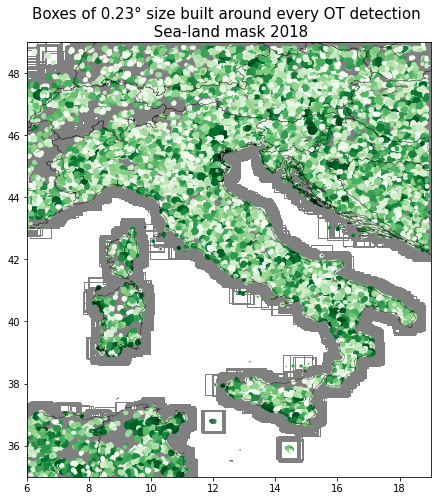

In [16]:
#TEST: plot OT detections and related boxes built around them:
ax = filt_OTset_2016_land.plot(markersize=10, figsize=(12, 8), column='otpmax', cmap='Greens',zorder=2)

ax.set_ylim(y_lim)
ax.set_xlim(x_lim)
#plt.autoscale(False)

#shapefiles    
for shp in sf_geo:
    shp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=3)

gpd.GeoDataFrame(filt_OTset_2016_land['geometry_25km_box'], columns=['geometry_25km_box']).rename(columns={'geometry_25km_box' : 'geometry'}).plot(ax=ax, facecolor="none", edgecolor='grey');
plt.title('Boxes of 0.23° size built around every OT detection \n Sea-land mask 2018', fontsize=15);


## 4.2) - Spatial matching with ESWD

filt_OTset_2016_land
filt_OTset_2017_land
filt_OTset_2018_land
filt_OTset_2019_land
filt_OTset_2020_land

all_OTset_2016_land
all_OTset_2017_land
all_OTset_2018_land
all_OTset_2019_land
all_OTset_2020_land

In [87]:
#define which set to consider for validation: filt_ or all_ 
OTset = all_OTset_2020_land

eswdSET = eswd_2020

In [88]:
#Select only QC1+ reports:
eswdSET = eswdSET[eswdSET['QC_level'] != 'QC0+']

In [89]:
OTset

,lon,lat,time,otpmax,geometry,dtmin,irbmin,geometry_25km_box
0,9.207144,35.090714,2020-04-03 13:00:00+00:00,0.61,POINT (9.20714 35.09071),-0.199997,227.209991,"POLYGON ((9.547143783569336 34.75071350097656,..."
1,9.171430,35.055000,2020-04-03 13:00:00+00:00,0.61,POINT (9.17143 35.05500),-0.560013,226.879990,"POLYGON ((9.511429634094238 34.71500030517578,..."
367,18.903143,42.548714,2020-04-05 07:00:00+00:00,0.66,POINT (18.90314 42.54871),-0.389999,215.580002,"POLYGON ((19.24314292907715 42.20871368408203,..."
368,6.139714,35.786999,2020-04-07 17:00:00+00:00,0.63,POINT (6.13971 35.78700),-0.110001,217.379990,"POLYGON ((6.479714241027832 35.44699874877929,..."
369,6.175429,35.785999,2020-04-07 17:00:00+00:00,0.63,POINT (6.17543 35.78600),-0.500000,216.979996,"POLYGON ((6.515428867340088 35.4459992980957, ..."
...,...,...,...,...,...,...,...,...
149034,18.198856,42.734287,2020-09-29 00:00:00+00:00,0.50,POINT (18.19886 42.73429),-1.339996,221.860001,"POLYGON ((18.53885635375977 42.39428726196289,..."
149035,18.236572,42.736286,2020-09-29 00:00:00+00:00,0.50,POINT (18.23657 42.73629),-0.830002,222.360001,"POLYGON ((18.576572265625 42.39628616333007, 1..."
149039,18.162144,42.696571,2020-09-29 00:00:00+00:00,0.50,POINT (18.16214 42.69657),-1.639999,221.599991,"POLYGON ((18.50214370727539 42.35657135009765,..."
149040,18.199856,42.699570,2020-09-29 00:00:00+00:00,0.50,POINT (18.19986 42.69957),-1.100006,222.129990,"POLYGON ((18.53985580444336 42.35956970214843,..."


In [90]:
eswdSET

,datetime,lat,lon,size,QC_level,Time_accuracy,Max_hailst_weight,Thickness_hail_layer,Total_damage,N_injured,N_killed,Impacts,geometry
0,2020-04-14 10:19:00,46.222,13.201,2.0,QC1,30M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.20100 46.22200)
1,2020-04-14 12:30:00,45.775,12.044,2.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.04400 45.77500)
2,2020-04-29 12:00:00,44.495,11.343,3.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (11.34300 44.49500)
3,2020-04-29 13:30:00,45.160,18.016,2.0,QC1,30M,NaN,2.0,NaN,NaN,NaN,NaN,POINT (18.01600 45.16000)
4,2020-05-02 09:45:00,45.409,13.967,NaN,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.96700 45.40900)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,2020-09-25 14:00:00,46.283,12.796,4.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.79600 46.28300)
664,2020-09-25 15:23:00,45.946,13.621,4.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.62100 45.94600)
665,2020-09-25 19:00:00,43.391,10.433,2.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.43300 43.39100)
666,2020-09-25 20:30:00,40.701,17.339,4.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (17.33900 40.70100)


In [91]:
eswd_HITTED = gpd.GeoDataFrame(columns=eswd.columns)
OTset_HITTING = gpd.GeoDataFrame(columns=OTset.columns)

#loop on OT detections
for OT_ind in OTset.index:
    
    OT = OTset[OTset.index == OT_ind]

    OTyear = int(OT.time.apply(lambda x: x.year))
    OTmonth = int(OT.time.apply(lambda x: x.month))
    OTday = int(OT.time.apply(lambda x: x.day))
    OThour = int(OT.time.apply(lambda x: x.hour))
    
    print(OT_ind)

    #select day before and above of OT timing
    OTtime_dAbove = pd.to_datetime(OT.time.item() + pd.to_timedelta(1, unit='d'))
    OTtime_dBefore = pd.to_datetime(OT.time.item() - pd.to_timedelta(1, unit='d'))
    OTtime_dAbove = OTtime_dAbove.replace(tzinfo=None)
    OTtime_dBefore = OTtime_dBefore.replace(tzinfo=None)

    #define eswd subset in the 3 days (before,present,and future) around OT timing: 
    #(this is done to make the loop more efficient!)
    """
    This step could be even more efficient by selecting directly only reports in a 1.5h temp window, for the moment
    lets try with +-1day and see if it is still too slow
    """
    eswd_subset = eswdSET[(eswdSET.datetime >= OTtime_dBefore) & (eswdSET.datetime <= OTtime_dAbove)]
    
    #loop on eswd reports
    for eswd_ind in eswd_subset.index:

        #calculate time delta between OT and eswd report:
        tdelta = pd.Timedelta(abs(OT.time.values[0] - eswd_subset.datetime[eswd_subset.index == eswd_ind].values[0]))
        
        #condition: if difference between OT and report timing is smaller than (+-)1h keep the report
        if tdelta <= timedelta(minutes=180):  #minutes=60 +-1h      #minutes=90  +-1.5h
            
            #condition on spatial neighbourhood: if eswd report falls inside OT box:
            if eswd_subset.geometry[eswd_ind].within(OTset.geometry_25km_box[OT_ind]):

                print('Hit!')
                eswd_HITTED = eswd_HITTED.append(eswd_subset[eswd_subset.index == eswd_ind])

                OTset_HITTING = OTset_HITTING.append(OTset[OTset.index == OT_ind])
    
"""
ALLA FINE DI TUTTO BISOGNA RIPULARE I DATASET HITTED E HITTING DAI DOPPIONI!
"""

0
1
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615


3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
Hit!
3066
Hit!
3067
Hit!
3068
Hit!
3069
Hit!
3070
Hit!
3071
Hit!
3072
Hit!
3073
Hit!
3074
Hit!
3075
Hit!
3076
Hit!
3077
Hit!
3078
Hit!
3079
Hit!
3080
Hit!
3081
Hit!
3082
Hit!
3083
3084
3085
3086
Hit!
3087
Hit!
3088
Hit!
3089
3090
3091
3092
Hit!
3093
Hit!
3094
Hit!
3095
3096
3097
Hit!
3098
Hit!
3099
Hit!
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
Hit!
3132
3133
3134
3135
3136
3137
3138
3139
Hit!
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
Hit!
3158
Hit!
3159
3160
Hit!
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207


5538
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741


7374
7375
7376
7377
7378
7379
7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
7458
7459
7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
Hit!
7535
7536
7537
7538
7539
7540
7541
7542
7543
Hit!
7544
Hit!
7545
7546
7547
7548
7549
7550
Hit!
7551
7552
7553
7554
Hit!
7555
Hit!
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567


9462
9463
9464
9465
9466
9474
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9497
9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9553
9554
9555
9560
9561
9562
9564
9565
9566
9765
9766
9772
9773
9774
9782
9783
9784
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10

11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
1166

Hit!
12765
Hit!
Hit!
Hit!
12766
Hit!
Hit!
Hit!
12767
Hit!
Hit!
Hit!
12768
Hit!
Hit!
Hit!
12769
12770
12771
Hit!
Hit!
12772
Hit!
Hit!
Hit!
12773
Hit!
Hit!
Hit!
12774
Hit!
Hit!
Hit!
12775
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
12776
Hit!
12777
12778
12779
12780
Hit!
12781
Hit!
Hit!
12782
Hit!
Hit!
Hit!
Hit!
12783
Hit!
12784
12785
12786
12787
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
12788
Hit!
Hit!
Hit!
Hit!
12789
12790
Hit!
Hit!
Hit!
Hit!
Hit!
12791
Hit!
Hit!
Hit!
Hit!
Hit!
12792
Hit!
Hit!
Hit!
Hit!
Hit!
12793
Hit!
Hit!
Hit!
Hit!
Hit!
12794
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
12795
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
12796
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
12797
Hit!
Hit!
Hit!
Hit!
Hit!
12798
Hit!
Hit!
Hit!
Hit!
Hit!
12799
Hit!
Hit!
Hit!
Hit!
Hit!
12800
Hit!
Hit!
Hit!
Hit!
Hit!
12801
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
12802
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
12

13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
Hit!
13208
Hit!
13209
Hit!
13210
Hit!
13211
Hit!
13212
Hit!
13213
Hit!
13214
Hit!
13215
Hit!
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
1

15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15083
15084
15086
15090
15091
15092
15106
15107
15108
15253
15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269
15270
15271
15272
15273
15274
15275
15276
15277
15278
15279
15280
15281
15282
15283
15284
15285
15286
15287
15288
15289
15290
15291
15292
15293
15294
15295
15296
15297
15298
15299
15300
15301
15302
15303
15304
15305
15306
15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15450
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
15462
15463
15464
15465
15466
15467
15468
15469
15470
15471
15472
15473
15474
15475
15476
15477
15478
15479
15480
15481
15482
15483
15484
15532
15584
15597
1563

17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577
17578
17579
17580
17581
17582
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
17597
17598
17599
17639
17640
17641
17642
17643
17644
17645
17646
17647
17648
17649
17650
17651
17652
17653
17654
17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17727
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17859
17860
17861
17862
17863
17864
17865
17866
17867
17868
17869
17870
17871
17872
17873
17874
17875
17876
17877
17878
17879
17880
17881
17882
17883
17884
17885
17886
17887
17888
17889
17890
17891
17892
17893
17894
17895
17896
17897
17898
17899
17900
17901
17902
17903
17904
17905
17906
17907
17908
17909
17910
17911
17912
17913
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
1791

18636
Hit!
18637
Hit!
18638
Hit!
18639
Hit!
18640
Hit!
18641
Hit!
Hit!
18642
Hit!
Hit!
18643
Hit!
18644
Hit!
18645
Hit!
Hit!
18646
Hit!
Hit!
18647
Hit!
Hit!
18648
Hit!
Hit!
18649
Hit!
Hit!
18650
Hit!
Hit!
18651
Hit!
Hit!
18652
Hit!
Hit!
18653
Hit!
Hit!
18654
Hit!
Hit!
18655
Hit!
Hit!
18656
Hit!
Hit!
18657
Hit!
Hit!
18658
Hit!
Hit!
18659
Hit!
Hit!
18660
18661
18662
18663
18664
18665
18666
18667
18668
18669
18670
18671
Hit!
Hit!
18672
Hit!
Hit!
18673
Hit!
Hit!
18674
Hit!
Hit!
18675
Hit!
Hit!
18676
Hit!
Hit!
18677
Hit!
Hit!
18678
Hit!
Hit!
18679
Hit!
Hit!
18680
Hit!
Hit!
18681
Hit!
Hit!
18682
Hit!
Hit!
18683
Hit!
Hit!
18684
18685
18686
18687
18688
18689
18690
18691
18692
18693
18694
18695
18696
18701
18702
18703
18704
18705
18706
18707
18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
18719
18720
18721
18722
18723
18724
18725
18726
18727
18728
18729
18730
18731
18732
18747
18748
18749
18750
18751
18752
18753
18754
18755
18756
18757
18758
18759
18760
18761
18762
18763
18764

20241
20242
20243
20244
20245
20246
20247
20248
20249
20250
20251
20252
20253
20254
20255
20256
20257
20258
20259
20260
20261
20262
20263
20264
20265
20266
20267
20268
20269
20270
20271
20272
20273
20274
20275
20276
20277
20278
20279
20305
20311
20312
20313
20314
20315
20316
20317
20318
20319
20320
20321
20322
20323
20324
20325
20326
20327
20328
20329
20330
20331
20332
20333
20334
20335
20336
20337
20338
20339
20340
20341
20342
20343
20344
20345
20346
20357
20358
20359
20360
20361
20378
20379
20380
20398
20399
20407
20411
20413
20414
20415
20417
20418
20422
20423
20425
20426
20428
20429
20439
20440
20443
20444
20445
20451
20452
20453
20454
20455
20456
20457
20458
20459
20460
20461
20462
20463
20467
20468
20469
20470
20471
20472
20473
20474
20475
20476
20477
20478
20479
20480
20481
20482
20483
20484
20485
20486
20487
20488
20489
20490
20491
20492
20493
20494
20495
20496
20497
20498
20499
20500
20501
20502
20503
20504
20505
20506
20507
20508
20509
20510
20511
20512
20513
20514
20515
2051

22047
22048
22049
22050
22051
22052
22053
22054
22055
22056
22057
22059
Hit!
Hit!
22060
Hit!
Hit!
22061
22062
22063
22064
22065
Hit!
Hit!
22066
Hit!
Hit!
22067
22068
22069
22070
22071
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083
22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
Hit!
Hit!
22112
Hit!
Hit!
22113
Hit!
Hit!
22114
Hit!
Hit!
22115
Hit!
Hit!
22116
Hit!
Hit!
22117
Hit!
Hit!
22118
Hit!
Hit!
22119
Hit!
Hit!
22120
Hit!
Hit!
22121
Hit!
Hit!
22122
Hit!
Hit!
22123
Hit!
Hit!
22124
Hit!
Hit!
22125
Hit!
Hit!
22126
Hit!
Hit!
22127
Hit!
Hit!
22128
Hit!
Hit!
22129
Hit!
Hit!
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
22161
22162
22166
22167
22168
22169
22180
22181
22182
22183
22184
22185
22212
22213
22214
22

23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
23673
23674
23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687
23688
23689
23690
23691
23692
23693
23694
23695
23696
23697
23698
23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709
23710
23711
23712
23713
23714
23715
23716
23717
23718
23719
23720
23721
23722
23723
23724
23725
23726
23727
23728
23729
23730
23731
23732
23733
23734
23735
23736
23737
23738
23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23755
Hit!
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828

24911
Hit!
24912
24913
24914
24915
24916
24917
24918
24919
24920
24921
24922
24923
24924
24925
24926
24929
24930
24935
Hit!
24936
Hit!
24937
Hit!
24938
24939
Hit!
24940
Hit!
24941
Hit!
24942
24943
24944
24945
24946
Hit!
24947
Hit!
24948
Hit!
24949
24950
24951
24952
24953
24954
24955
24956
24957
24958
24959
24960
24961
24962
24963
24964
24965
24966
24967
24968
24969
24970
24971
24972
24973
24974
24975
24976
24977
24978
24979
24980
24981
24982
24983
24984
24985
24986
24987
24988
24989
24990
24991
24992
24993
24994
24995
Hit!
Hit!
24996
Hit!
Hit!
24997
Hit!
24998
24999
25000
25001
25002
Hit!
Hit!
25003
Hit!
Hit!
25004
Hit!
Hit!
25005
Hit!
25006
25007
Hit!
Hit!
25008
Hit!
Hit!
25009
25010
25011
25012
25013
25014
25015
25016
25017
25018
25019
25020
25021
25022
25023
25024
25025
25026
25027
25028
25029
25030
25031
25032
25033
25034
25035
25036
25037
25038
25039
25040
25041
25042
25043
25044
25045
25046
25047
25048
25049
25050
25051
25052
25053
Hit!
25054
Hit!
25055
Hit!
25056
Hit!
25057
Hit!

26016
Hit!
26017
Hit!
26018
Hit!
26019
Hit!
26020
Hit!
26021
26022
26023
26024
26025
26026
26028
Hit!
26029
Hit!
26030
Hit!
26031
26032
26033
26034
26040
Hit!
26041
Hit!
26042
Hit!
26043
26044
26052
Hit!
26068
26069
Hit!
26070
Hit!
26071
Hit!
26072
Hit!
26073
Hit!
26074
Hit!
26075
Hit!
26076
Hit!
26078
Hit!
26079
26080
26081
26082
26083
26084
26085
26086
26087
Hit!
26088
26089
26090
26091
26092
26093
26094
26095
Hit!
26096
26097
26098
26099
26100
26101
26102
26103
26104
26105
26106
26107
26108
26109
26110
26111
26112
26113
26114
26115
26116
26117
26118
26119
26120
26121
26122
26123
26124
26125
26126
26127
26128
26129
26130
26131
26132
26133
26134
26135
26136
26137
26138
26139
26140
26141
26142
26143
26144
26145
26146
26147
26148
26149
26150
26151
26152
26153
26154
26155
26156
26157
26158
26159
26160
26161
26162
26163
26164
26165
26166
26167
26168
26169
26170
26171
26172
26173
26174
26175
26176
26177
26178
26179
26180
26181
26182
26183
26184
26185
26186
26187
26188
26189
26190
26191
261

Hit!
27296
Hit!
Hit!
Hit!
Hit!
27297
Hit!
Hit!
Hit!
Hit!
27298
Hit!
Hit!
Hit!
Hit!
27299
Hit!
Hit!
Hit!
Hit!
27300
Hit!
Hit!
Hit!
Hit!
27301
Hit!
Hit!
Hit!
Hit!
27302
Hit!
Hit!
Hit!
Hit!
27303
Hit!
Hit!
Hit!
Hit!
27304
Hit!
Hit!
Hit!
Hit!
27305
Hit!
Hit!
Hit!
Hit!
27306
Hit!
Hit!
Hit!
Hit!
27307
27308
27309
27310
Hit!
Hit!
27311
27312
27313
27314
27315
27316
27317
27318
27319
27320
27321
27322
Hit!
Hit!
27323
27324
27325
27326
27327
27328
27329
27330
27331
27332
27333
27334
27335
27336
27337
Hit!
Hit!
27338
27339
27340
27341
27342
27343
27344
27345
27346
Hit!
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
27372
27373
27374
27375
27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
27392
27393
27394
27395
27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409
27410
27411
27412
27413
27414
27415
27416
27417
27418
27

28486
Hit!
Hit!
Hit!
28487
Hit!
Hit!
Hit!
28488
Hit!
Hit!
Hit!
28489
Hit!
Hit!
28490
Hit!
28491
Hit!
28492
28493
28494
28495
28496
Hit!
Hit!
Hit!
28497
Hit!
Hit!
Hit!
28498
Hit!
Hit!
Hit!
28499
Hit!
28500
Hit!
28501
28502
28503
28504
28505
28506
28507
28508
28509
28510
28511
28512
28513
Hit!
Hit!
Hit!
28514
Hit!
Hit!
Hit!
28515
Hit!
Hit!
Hit!
28516
Hit!
Hit!
Hit!
28517
Hit!
Hit!
Hit!
28518
Hit!
Hit!
Hit!
28519
Hit!
Hit!
Hit!
28520
Hit!
Hit!
28521
Hit!
28522
Hit!
Hit!
Hit!
28523
Hit!
Hit!
Hit!
28524
Hit!
Hit!
Hit!
28525
Hit!
Hit!
Hit!
28526
Hit!
Hit!
Hit!
28527
Hit!
Hit!
28528
Hit!
28529
Hit!
28530
28531
28532
28533
28534
28535
Hit!
28536
Hit!
28537
Hit!
28538
Hit!
28539
Hit!
28540
Hit!
28541
Hit!
28542
Hit!
28543
Hit!
28544
Hit!
28545
Hit!
28546
Hit!
28547
Hit!
28552
Hit!
28559
28560
28561
28562
28563
28564
28565
28566
28567
28568
28569
28570
28571
28572
28573
28574
28575
28576
28577
28578
28579
28580
28581
28582
28583
28584
28585
28586
28587
28588
28589
28590
28591
28592
28593
28594
2

29656
Hit!
Hit!
Hit!
29657
Hit!
Hit!
29658
Hit!
Hit!
Hit!
29659
Hit!
Hit!
Hit!
29660
Hit!
Hit!
Hit!
29661
Hit!
29662
Hit!
29663
Hit!
29664
Hit!
29665
Hit!
29666
Hit!
29667
Hit!
29668
Hit!
29669
Hit!
29670
Hit!
29671
Hit!
29672
Hit!
29673
29674
29675
29676
29677
29678
29679
29680
29681
29682
29683
29684
29685
29686
29687
29688
29689
29690
29691
29692
29693
29694
29695
29696
29697
29698
29699
29700
29701
29702
29703
29704
29705
29706
29707
29708
29709
29710
29711
29712
29713
29714
29715
29716
29717
29718
29719
29720
29721
29722
29723
29724
29725
29726
29727
29728
29729
29730
29731
29732
29733
29734
29735
29736
29737
29738
29739
29740
29741
29742
29743
29744
29745
29746
29747
29748
29749
29750
29751
29752
29753
29754
29755
29756
29757
29758
29759
29760
29761
29762
29763
29764
29765
29766
29767
29768
29769
29770
29771
29772
29773
29774
29775
29776
29777
29778
29779
29780
29781
29782
29783
29784
29785
29786
29787
29788
29789
29790
29791
29792
29793
29794
29795
29796
29797
29798
29799
29800


30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870
30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894
Hit!
30895
Hit!
30896
Hit!
30897
Hit!
30898
Hit!
30899
30900
30901
30902
30903
30904
30905
30906
30907
30908
30909
30910
30911
30912
30913
30914
30915
309

31991
31992
31993
31994
31995
31996
Hit!
Hit!
31997
Hit!
Hit!
31998
Hit!
31999
Hit!
32000
Hit!
32001
32002
32003
32004
32005
32006
32007
32008
32009
32010
Hit!
Hit!
32011
Hit!
32012
Hit!
32013
Hit!
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
Hit!
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
Hit!
32050
Hit!
32051
Hit!
32052
Hit!
32053
Hit!
32054
Hit!
32055
Hit!
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
Hit!
32078
Hit!
32079
32080
Hit!
32081
Hit!
32082
Hit!
32083
Hit!
32084
Hit!
32085
Hit!
32086
32087
Hit!
32088
Hit!
32089
Hit!
32090
Hit!
32091
Hit!
32092
Hit!
32093
Hit!
32094
Hit!
32095
Hit!
32096
Hit!
32097
Hit!
32098
Hit!
32099
Hit!
32100
Hit!
32101
Hit!
32102
Hit!
32103
Hit!
32104
Hit!
32105
Hit!
32106
Hit!
32107
Hit!
32108
Hit!
32109
Hit!
32110
Hit!
32111
Hit!
32112
Hit

33020
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33021
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33022
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33023
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33024
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33025
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33026
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33027
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33028
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33029
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33030
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33031
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33032
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33033
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33034
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33035
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33036
Hit!
Hit!
Hit!
Hit!
33037
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
33038
H

33931
Hit!
33932
Hit!
33933
Hit!
33934
Hit!
33935
Hit!
33936
Hit!
33937
Hit!
33938
Hit!
33939
Hit!
33940
Hit!
33941
Hit!
33942
Hit!
33943
Hit!
33944
Hit!
33945
Hit!
33946
Hit!
Hit!
33947
Hit!
33948
Hit!
33949
Hit!
33950
Hit!
33951
Hit!
Hit!
33952
Hit!
33953
Hit!
Hit!
33954
Hit!
33955
Hit!
33956
Hit!
33957
33958
Hit!
Hit!
Hit!
Hit!
33959
Hit!
Hit!
Hit!
Hit!
33960
Hit!
Hit!
Hit!
Hit!
33961
Hit!
Hit!
Hit!
Hit!
Hit!
33962
Hit!
Hit!
Hit!
Hit!
Hit!
33963
Hit!
Hit!
Hit!
Hit!
Hit!
33964
Hit!
Hit!
Hit!
Hit!
Hit!
33965
Hit!
Hit!
33966
Hit!
33967
Hit!
33968
Hit!
33969
33970
33971
33972
Hit!
Hit!
Hit!
Hit!
33973
Hit!
Hit!
Hit!
Hit!
33974
Hit!
Hit!
Hit!
Hit!
33975
Hit!
Hit!
Hit!
Hit!
33976
Hit!
Hit!
Hit!
Hit!
Hit!
33977
Hit!
Hit!
Hit!
Hit!
Hit!
33978
Hit!
Hit!
Hit!
Hit!
Hit!
33979
Hit!
Hit!
Hit!
Hit!
Hit!
33980
Hit!
Hit!
Hit!
Hit!
Hit!
33981
33982
33983
Hit!
Hit!
Hit!
Hit!
33984
Hit!
Hit!
Hit!
Hit!
33985
Hit!
Hit!
Hit!
Hit!
33986
Hit!
Hit!
Hit!
Hit!
33987
Hit!
Hit!
Hit!
Hit!
33988
Hit!
Hit!
Hit!
Hi

Hit!
34643
Hit!
Hit!
Hit!
34644
Hit!
Hit!
Hit!
34645
Hit!
Hit!
34646
Hit!
34647
Hit!
34648
Hit!
34649
Hit!
34650
Hit!
Hit!
Hit!
34651
Hit!
Hit!
34652
Hit!
34653
Hit!
34654
Hit!
34655
Hit!
34656
Hit!
Hit!
Hit!
34657
34658
34659
Hit!
Hit!
34660
Hit!
34661
Hit!
34662
34663
34664
Hit!
Hit!
34665
Hit!
Hit!
34666
Hit!
Hit!
34667
Hit!
34668
Hit!
34669
Hit!
34670
Hit!
34671
Hit!
Hit!
34672
Hit!
Hit!
34673
Hit!
Hit!
34674
Hit!
Hit!
34675
Hit!
Hit!
34676
Hit!
Hit!
34677
Hit!
Hit!
34678
Hit!
Hit!
34679
Hit!
Hit!
34680
Hit!
Hit!
34681
Hit!
Hit!
34682
Hit!
Hit!
34683
Hit!
34684
Hit!
Hit!
34685
Hit!
Hit!
34686
Hit!
Hit!
34687
Hit!
Hit!
34688
Hit!
34689
Hit!
Hit!
34690
Hit!
Hit!
34691
Hit!
Hit!
34692
Hit!
34693
Hit!
34694
Hit!
34695
Hit!
34696
Hit!
34697
Hit!
34698
Hit!
34699
Hit!
34700
Hit!
34701
Hit!
34702
Hit!
34703
Hit!
34704
Hit!
34705
Hit!
34706
Hit!
34707
Hit!
34708
Hit!
34709
Hit!
34710
Hit!
34711
Hit!
34712
Hit!
34713
Hit!
34714
Hit!
34715
Hit!
34716
Hit!
34717
Hit!
34718
Hit!
34719
Hit!
347

35931
35932
35933
35934
35935
35936
35937
35938
35939
35940
35941
35942
35943
35944
35945
35946
35947
35948
35949
35950
35951
35952
35953
35954
35955
35956
35957
35958
35959
35960
35961
35962
35963
35964
35965
35966
35967
35968
35969
35970
35971
35972
35973
35974
35975
35976
35977
35978
35979
35980
35981
35984
35985
35986
35987
35988
35989
35990
35991
35992
35993
35994
35995
35996
35997
35998
35999
36000
36001
36002
36003
36004
36005
36012
36013
36020
36021
36022
36023
36024
36028
36029
36030
36031
36032
36035
36036
36037
36038
36040
36041
36042
36043
36044
36045
36051
36094
36095
36096
36097
36098
36099
36100
36101
36102
36103
36104
36105
36106
36107
36108
36109
36110
36111
36112
36113
Hit!
Hit!
36114
Hit!
Hit!
36115
Hit!
Hit!
36116
Hit!
Hit!
36117
Hit!
Hit!
36118
36119
36120
36121
36122
36123
36124
36125
36126
36127
36128
36129
36130
36131
36132
36133
36134
36135
36136
36137
36138
36139
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151
36152
36153
36154
36155
36

Hit!
Hit!
Hit!
Hit!
Hit!
36986
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
36987
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
36988
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
36989
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
36990
36991
36992
36993
36994
36995
36996
36997
36998
36999
37000
37001
37002
37003
37004
37005
37006
37007
37008
37009
37010
37011
37012
37013
37014
37015
37016
37017
37018
37019
37020
37021
37022
37023
37024
37025
37026
37027
37028
37029
37030
37031
37032
37033
37034
37035
37036
37037
37038
37039
37040
37041
37042
37043
37044
37045
37046
37047
37048
37049
37050
37051
37052
37053
37054
37055
37056
37057
37058
37059
37060
37061
37062
37063
37064
37065
37066
37067
37068
37069
37070
37071
37072
37073
37074
37075
37076
37077
37078
37079
37080
37081
37082
37083
37084
37085
37086
37087
37088
37089
37090
37091
37092
37093
37094
37095
37096
37097
37098
37099
37100
37101
37102
37103
37104
37105
37106
37107
37108
37109
37110
37111
37112
37113
37114
37115
37116
37117
37118
37119
37120
37121
37122
37123
37124
37125
37126
37127
371

37707
37708
37709
37710
37711
37712
37713
37714
37715
37716
37717
37718
37719
37720
37721
37722
37723
37724
37725
37726
37727
37728
37729
37730
37731
37732
37733
37734
37735
37736
37737
37738
37739
37740
37741
37742
37743
37744
37745
37746
37747
37748
37749
37750
37751
37752
37753
37754
37755
37756
37757
37758
37759
37760
37761
37762
37763
37764
37765
37766
37767
37768
37769
37770
37771
37772
37773
37774
37775
37776
37777
37778
37779
37780
37781
37782
37783
37784
37785
37786
37787
37788
37789
37790
37791
37792
37793
37794
37795
37796
37797
37798
37799
37800
37801
37802
37803
37804
37805
37806
37807
37808
37809
37810
37811
37812
37813
37814
37815
37816
37817
37818
37819
37820
37821
37822
37823
37824
37825
37826
37827
37828
37829
37830
37831
37832
37833
37834
37835
37836
37837
37838
37839
37840
37841
37842
37843
37844
37845
37846
37847
37848
37849
37850
37851
37852
37853
37854
37855
37856
37857
37858
37859
37860
37861
37862
37863
37864
37865
37866
37867
37868
37869
37870
37871
37872
3787

Hit!
Hit!
38559
Hit!
Hit!
Hit!
Hit!
38560
Hit!
Hit!
38561
Hit!
38562
Hit!
38563
Hit!
38564
38565
38566
Hit!
Hit!
Hit!
Hit!
38567
Hit!
Hit!
Hit!
Hit!
38568
Hit!
Hit!
Hit!
38569
Hit!
Hit!
Hit!
38570
Hit!
Hit!
38571
Hit!
38572
Hit!
38573
Hit!
38574
38575
38576
38577
38578
38579
Hit!
Hit!
Hit!
Hit!
38580
Hit!
Hit!
Hit!
Hit!
38581
Hit!
Hit!
Hit!
38582
Hit!
Hit!
Hit!
38583
Hit!
Hit!
38584
Hit!
38585
Hit!
38586
Hit!
38587
38588
Hit!
Hit!
Hit!
Hit!
38589
Hit!
Hit!
Hit!
38590
Hit!
Hit!
Hit!
38591
Hit!
Hit!
38592
Hit!
38593
Hit!
38594
Hit!
38595
38596
38597
38598
38599
38600
38601
Hit!
Hit!
Hit!
Hit!
38602
Hit!
Hit!
Hit!
Hit!
38603
Hit!
Hit!
Hit!
38604
Hit!
Hit!
Hit!
38605
Hit!
Hit!
38606
Hit!
38607
Hit!
38608
Hit!
38609
38610
38611
38612
38613
38614
38615
38616
38617
Hit!
Hit!
Hit!
Hit!
38618
Hit!
Hit!
Hit!
Hit!
38619
Hit!
Hit!
Hit!
Hit!
38620
Hit!
Hit!
Hit!
Hit!
38621
Hit!
Hit!
Hit!
Hit!
38622
Hit!
Hit!
Hit!
38623
Hit!
Hit!
Hit!
38624
Hit!
Hit!
38625
Hit!
38626
Hit!
38627
Hit!
38628
38629
3863

39822
39823
39824
39825
39826
39827
39828
39829
39830
39831
39832
39833
39834
39835
39836
39837
39838
39839
39840
39841
39842
39843
39844
39845
39846
39847
39848
39849
39850
39851
39852
39853
39854
39855
39856
39857
39858
39859
39860
39861
39862
39863
39864
39865
39866
39867
39868
39869
39870
39871
39872
39873
39874
39875
39876
39877
39878
39879
39880
39881
39882
39883
39884
39885
39886
39887
39888
39889
39890
39891
39892
39893
39894
39895
39896
39897
39898
39899
39900
39901
39902
39903
39904
39905
39906
39907
39908
39909
39910
39911
39912
39913
39914
39915
39916
39917
39918
39919
39920
39921
39922
39923
39924
39925
39926
39927
39928
39929
39930
39931
39932
39933
39934
39935
39936
39937
39938
39939
39940
39941
39942
39943
39944
39945
39946
39947
39948
39949
39950
39951
39952
39953
39954
39955
39956
39957
39958
39959
39960
39961
39962
39963
39964
39965
39966
39967
39968
39969
39970
39971
39972
39973
39974
39975
39976
39977
39978
39979
39980
39981
39982
39983
39984
39985
39986
39987
3998

41197
41198
41199
41200
41201
41202
41203
41204
41205
41206
41207
41208
41209
41210
41211
41212
41213
41214
41215
41216
41217
41218
41219
41220
41221
41222
41223
41224
41225
41226
41227
41228
41229
41230
41231
41232
41233
41234
41235
41236
41237
41238
41239
41240
41241
41242
41243
41244
41245
41246
41247
41248
41249
41250
41251
41252
41253
41254
41255
41256
41257
41258
41259
41260
41261
41262
41263
41264
41265
41266
41267
41268
41269
41270
41271
41272
41273
41274
41277
41279
41280
41281
41282
41283
41284
41285
41290
41291
41292
41293
41294
41295
41296
41297
41302
41305
41320
41321
41322
41323
41324
41325
41326
41327
41328
41329
41330
41331
41332
41333
41334
41335
41336
41337
41343
41344
41345
41346
41347
41348
41349
41350
41361
41362
41363
41364
41365
41366
41367
41368
41369
41371
41380
41381
41382
41383
41384
41387
41388
41390
41397
41398
41399
41400
41404
41414
41415
41423
41424
41425
41426
41432
41433
41434
41435
41438
41439
41440
41441
41442
41443
41444
41445
41446
41447
41448
4144

43796
43797
43798
43799
43800
43801
43802
43803
43804
43805
43806
43807
43808
43809
43810
43811
43812
43813
43814
43815
43816
43817
43818
43819
43820
43821
43822
43823
43824
43825
43826
43827
43828
43829
43830
43831
43832
43833
43834
43835
43836
43837
43838
43839
43840
43841
43842
43843
43844
43845
43846
43847
43848
43849
43850
43851
43852
43853
43854
43855
43856
43857
43858
43859
43860
43861
43862
43863
43864
43865
43866
43867
43868
43869
43870
43871
43872
43873
43874
43875
43876
43877
43878
43879
43880
43881
43882
43883
43884
43885
43886
43887
43888
43889
43890
43891
43892
43893
43894
43895
43896
43897
43898
43899
43900
43901
43902
43903
43904
43905
43906
43907
43908
43909
43910
43911
43912
43913
43914
43915
43916
43917
43918
43919
43920
43921
43922
43923
43924
43925
43926
43927
43928
43929
43930
43931
43932
43933
43934
43935
43936
43937
43938
43939
43940
43941
43942
43943
43944
43945
43946
43947
43948
43949
43963
43964
43965
43976
43977
43978
43979
43980
43981
43982
43983
43995
4399

Hit!
Hit!
45645
Hit!
Hit!
45646
Hit!
45647
Hit!
Hit!
45648
Hit!
Hit!
45649
Hit!
Hit!
Hit!
45650
Hit!
Hit!
45651
Hit!
Hit!
Hit!
45652
Hit!
Hit!
45653
45654
45655
45656
45657
45658
45659
45660
45661
45662
45663
45664
45665
45666
45667
45668
45669
45670
45671
45672
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45673
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45674
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45675
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45676
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45677
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45678
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45679
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45680
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45681
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45682
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45683
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45684
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45685
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45686
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
45687
Hit!
Hit!
Hit!
Hit!
Hit!
45688
Hit!
Hit!
Hit!
45689
Hit!
45690
45691
Hit

Hit!
46525
46526
46527
46528
46529
46530
46531
46532
46533
46534
46535
46536
46537
46538
46539
46540
Hit!
46541
Hit!
46542
Hit!
46543
Hit!
46544
Hit!
46545
46546
46547
46548
46549
46550
46551
46552
46553
46554
46555
46556
46557
46558
46559
46560
46561
46562
46563
46564
46565
46566
Hit!
46567
Hit!
46568
Hit!
46569
Hit!
46570
Hit!
46571
Hit!
46572
46573
46574
46575
46576
46577
46578
46579
46580
46581
46582
46583
46584
46585
46586
46587
46588
46589
46590
46591
46592
46593
46594
Hit!
46595
Hit!
46596
Hit!
46597
Hit!
46598
Hit!
46599
46600
46601
46602
46603
46604
46605
46606
46607
46608
46609
46610
46611
46612
46613
46614
46615
46616
46617
Hit!
46618
Hit!
46619
Hit!
46620
46621
46622
46623
46624
46625
46626
46627
46628
46629
46630
46631
46632
46633
46634
46635
46636
46637
46638
46639
46640
46641
46642
46643
46644
46645
46646
46647
46648
46649
46650
46651
46652
46653
46654
46655
46656
46657
46658
46659
46660
46661
46662
46663
46664
46665
46666
46667
46668
46669
46670
46671
46672
46673
46674


47826
Hit!
47827
Hit!
47828
Hit!
47829
Hit!
47830
47831
47832
47833
47834
47835
47836
47837
47838
47839
47840
47841
47842
47843
47844
Hit!
47845
Hit!
47846
Hit!
47847
Hit!
47848
Hit!
Hit!
47849
Hit!
Hit!
47850
Hit!
Hit!
47851
Hit!
Hit!
47852
47853
47854
47855
47856
47857
47858
47859
47860
47861
Hit!
47862
Hit!
47863
Hit!
Hit!
47864
Hit!
Hit!
47865
Hit!
Hit!
47866
Hit!
Hit!
47867
47868
47869
47870
47871
47872
47873
47874
47875
47876
47877
47878
47879
47880
47881
47882
Hit!
47883
47884
47885
47886
47887
47888
47889
47890
47891
47892
47893
47894
47895
47896
47897
47898
47899
47900
47901
47902
47903
47904
47905
47906
47907
47908
47909
47910
47911
47912
47913
47914
47915
47916
47917
47918
47919
47920
47921
47922
47923
47924
47925
47926
47927
47928
47929
47930
47931
47932
47933
47934
47935
47936
47937
47938
Hit!
Hit!
47939
47940
47941
47942
47943
Hit!
47944
Hit!
Hit!
47945
Hit!
Hit!
47946
Hit!
Hit!
47947
47948
47949
47950
47951
Hit!
47952
Hit!
47953
Hit!
47954
Hit!
Hit!
47955
Hit!
Hit!
47956

Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48295
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48296
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48297
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48298
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48299
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48300
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48301
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48302
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48303
Hit!
Hit!
Hit!
Hit!
Hit!
H

48465
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48466
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48467
Hit!
Hit!
Hit!
Hit!
Hit!
48468
Hit!
Hit!
48469
Hit!
Hit!
48470
Hit!
Hit!
48471
Hit!
48472
Hit!
48473
48474
48475
48476
48477
48478
48479
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48480
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48481
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48482
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48483
Hit!
Hit!
Hit!
Hit!
Hit!
48484
Hit!
Hit!
48485
Hit!
Hit!
48486
Hit!
Hit!
48487
Hit!
48488
Hit!
48489
48490
48491
48492
48493
48494
48495
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!

Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48622
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48623
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48624
Hit!
48625
Hit!
48626
Hit!
48627
48628
48629
48630
48631
48632
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48633
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48634
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48635
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48636
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48637
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
48638
Hit!
Hit!
Hit!
Hit!
Hit!
Hit

48730
Hit!
Hit!
Hit!
Hit!
48731
Hit!
48732
Hit!
48733
Hit!
Hit!
Hit!
Hit!
48734
Hit!
48735
Hit!
48736
Hit!
48737
48738
48739
48740
48741
48742
48743
48744
48745
48746
48747
48748
48749
48750
48751
48752
48753
48754
48755
48756
48757
48758
48759
48760
48761
48762
48763
48764
48765
48766
48767
48768
48769
48770
48771
48772
48773
48774
48775
48776
48777
48778
48779
48780
48781
48782
48783
48784
48785
48786
48787
48788
48789
48790
48791
48792
48793
48794
48795
48796
48797
48798
48799
48800
48801
48802
48803
48804
48805
48806
48807
48808
48809
48810
48811
48812
48813
48814
48815
48816
48817
48818
48819
48820
48821
48822
48823
48824
48825
48826
48827
48828
48829
48830
48831
48832
48833
48834
48835
Hit!
Hit!
48836
Hit!
Hit!
48837
Hit!
Hit!
48838
Hit!
Hit!
48839
Hit!
Hit!
48840
Hit!
Hit!
48841
Hit!
Hit!
48842
Hit!
Hit!
48843
Hit!
Hit!
48844
48845
48846
48847
48848
48849
48850
48851
48852
48853
48854
48855
48856
48857
48858
48859
48860
48861
48862
48863
48864
48865
48866
48867
48868
48869
48870

49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
49997
49998
49999
50000
50001
50002
50003
50004
50005
50006
50007
50008
50009
50010
50011
50012
50013
50014
50015
50016
50017
50018
50019
50020
50021
50022
50023
50024
50025
50026
50027
50028
50029
50030
50031
50032
50033
50034
50035
50036
50037
50038
50039
50040
50041
50042
50043
50044
50045
50046
50047
50048
50049
50050
50051
50052
50053
50054
50055
50056
50057
50058
50059
50060
50061
50062
50063
50064
50065
50066
50067
50068
50069
50070
50071
50072
50073
50074
50075
50076
50077
50078
50079
50080
50081
50082
50083
50084
50085
50086
50087
50088
50089
50090
50091
50092
50093
50094
50095
50096
50097
50098
50099
50100
50101
50102
50103
50104
50105
50106
50107
50108
50109
50110
50111
50112
50113
50114
50115
50116
50117
50118
50119
50120
50121
50122
50123
50124
50125
50126
50127
50128
50129
50130
50131
50132
50133
50134
50135
50136
50137
50138
50139
50140
50141
50142
50143
50144
50145
50146
50147
50148
50149
50150
50151
50152
5015

51395
51396
51397
51398
51399
51400
51401
51402
51403
51404
51405
51406
51407
51408
51409
51410
51411
51412
51413
51414
51415
51416
51417
51418
51419
51420
51421
51422
51423
51424
51425
51426
51427
51428
51429
51430
51431
51432
51433
51434
51435
51436
51437
51438
51439
51440
51441
51442
51443
51444
51445
51446
51447
51448
51449
51450
51451
51452
51453
51454
51455
51456
51457
51458
51459
51460
51461
51462
51463
51464
51465
51466
51467
51468
51469
51470
51471
51472
51473
51474
51475
51476
51477
51478
51479
51480
51481
51482
51483
51484
51485
51486
51487
51488
51489
51490
51491
51492
51493
51494
51495
51496
51497
51498
51499
51500
51501
51502
51503
51504
51505
51506
51507
51508
51509
51510
51511
51512
51513
51514
51515
51516
51517
51518
51519
51520
51521
51522
51523
51524
51525
51526
51527
51528
51529
51530
51531
51532
51533
51534
51535
51536
51537
51538
51539
51540
51541
51542
51543
51544
51545
51546
51547
51548
51549
51550
51551
51552
51553
51554
51555
51556
51557
51558
51559
51560
5156

52849
52850
52851
52852
52853
52854
52855
52856
52857
52858
52859
52860
52861
52862
52863
52864
52865
52866
52867
52868
52869
52870
52871
52872
52873
52874
52875
52876
52877
52878
52879
52880
52881
52882
52883
52884
52887
52888
52889
52890
52891
52892
52893
52894
52895
52898
52899
52900
52901
52902
52903
52904
52905
52906
52907
52908
52909
52910
52911
52912
52913
52914
52915
52916
52917
52918
52919
52920
52921
52922
52923
52924
52925
52926
52927
52928
52929
52930
52931
52932
52933
52934
52935
52936
52937
52938
52939
52940
52941
52942
52943
52944
52945
52946
52947
52948
52949
52950
52951
52952
52953
52954
52955
52956
52957
52958
52959
52960
52961
52962
52963
52964
52965
52966
52967
52968
52969
52970
52971
52972
52973
52974
52975
52976
52977
52978
52979
52980
52981
52982
52983
52984
52985
52986
52987
52988
52989
52990
52991
52992
52993
52994
52995
52996
52997
52998
52999
53000
53001
53002
53003
53004
53005
53006
53007
53008
53009
53010
53011
53012
53013
53014
53015
53016
53017
53018
5301

54931
54932
54933
54934
54935
54936
54937
54938
54939
54940
54941
54942
54943
54944
54945
54946
54947
54948
54949
54950
54963
54964
54965
54970
54971
55014
55015
55016
55017
55018
55019
55020
55021
55022
55023
55024
55025
55026
55027
55028
55029
55030
55031
55032
55033
55034
55035
55036
55037
55038
55039
55040
55041
55042
55043
55044
55045
55046
55047
55048
55049
55050
55051
55052
55053
55054
55055
55056
55057
55058
55059
55060
55061
55062
55063
55064
55066
55068
55069
55082
55083
55084
55085
55088
55091
55103
55141
55142
55143
55144
55145
55146
55147
55148
55149
55150
55151
55152
55153
55154
55155
55156
55157
55158
55159
55160
55161
55162
55163
55164
55165
55166
55167
55168
55169
55170
55171
55172
55173
55174
55175
55176
55177
55178
55179
55180
55181
55182
55183
55184
55185
55186
55187
55188
55189
55190
55191
55192
55193
55194
55195
55196
55214
55215
55216
55217
55218
55219
55220
55221
55222
55223
55224
55225
55226
55227
55228
55229
55230
55231
55232
55233
55234
55235
55236
55237
5523

57220
57221
57222
57223
57224
57225
57226
57227
57228
57229
57230
57231
57232
57233
57234
57235
57236
57237
57238
57239
57240
57241
57242
57243
57244
57245
57246
57247
57248
57249
57250
57251
57252
57253
57254
57255
57256
57257
57258
57259
57260
57261
57262
57263
57264
57265
57266
57267
57268
57269
57270
57271
57272
57273
57274
57275
57276
57277
57278
57279
57280
57281
57282
57283
57284
57285
57286
57290
57291
57292
57293
57294
57295
57296
57297
57301
57302
57303
57304
57305
57306
57313
57314
57315
57316
57323
57325
57326
57327
57328
57329
57330
57331
57332
57333
57334
57335
57336
57337
57338
57339
57340
57341
57342
57343
57344
57345
57346
57347
57348
57349
57350
57351
57352
57353
57354
57355
57356
57357
57358
57359
57360
57361
57362
57363
57364
57365
57366
57367
57368
57369
57370
57371
57372
57373
57374
57375
57376
57377
57378
57379
57380
57381
57382
57383
57384
57385
57386
57387
57388
57389
57390
57391
57392
57393
57394
57395
57396
57397
57398
57399
57400
57401
57402
57403
57404
5740

59165
59166
59167
59168
59169
59170
59171
59172
59173
59174
59175
59176
59177
59178
59179
59180
59181
59182
59183
59186
59187
59188
59189
59190
59191
59192
59193
59194
59195
59196
59197
59198
59199
59200
59201
59202
59203
59204
59205
59206
59207
59208
59209
59210
59211
59212
59213
59214
59215
59216
59217
59218
59219
59220
59221
59222
59223
59224
59225
59226
59227
59228
59229
59231
59232
59233
59235
59236
59237
59238
59286
59381
59382
59383
59384
59385
59386
59387
59388
59717
59720
59799
59800
59801
59802
59803
59804
59805
59853
59867
59868
59869
59870
59871
59872
59873
59874
59875
59876
59877
59878
59888
59889
59890
59891
59892
59893
59894
59895
59896
59897
59898
59899
59900
59903
59904
59906
59907
59908
59909
59910
59911
59912
59913
59914
59915
59916
59917
59918
59919
59920
59921
59922
59923
59924
59925
59926
59927
59928
59929
59930
59931
59932
59933
59934
59935
59936
59937
59938
59939
59940
59941
59942
59943
59944
59945
59946
59947
59948
59949
59950
59951
59952
59953
59954
59955
5995

61497
61498
61499
61500
61501
61502
61503
61504
61505
61506
61507
61508
61509
61510
61511
61512
61513
61514
61515
61516
61517
61518
61519
61520
61521
61522
61523
61524
61525
61526
61527
61528
61529
61530
61531
61532
61533
61534
61535
61536
61537
61538
61539
61540
61541
61542
61543
61544
61545
61546
61547
61548
61549
61550
61551
61552
61553
61554
61555
61556
61557
61558
61559
61560
61561
61562
61563
61564
61565
61566
61567
61568
61569
61570
61571
61572
61573
61574
61575
61576
61577
61578
61579
61580
61581
61582
61583
61584
61585
61586
61587
61588
61589
61590
61591
61592
61593
61594
61595
61596
61597
61598
61599
61600
61601
61602
Hit!
61603
Hit!
61604
61605
61606
61607
61608
61609
61610
61611
61612
61613
61614
61615
61616
61617
61618
61619
61620
61621
Hit!
61622
Hit!
61623
61624
61625
61626
Hit!
61627
Hit!
61628
Hit!
61629
61630
Hit!
61631
Hit!
61632
Hit!
61633
Hit!
61634
61635
61636
61637
61638
61639
61640
Hit!
61641
Hit!
61642
Hit!
61643
Hit!
61644
Hit!
61645
Hit!
61646
Hit!
61647
Hit!

62821
62822
62823
62824
62825
62826
62827
62828
62829
62830
62831
62832
62833
62834
62835
62836
62837
62838
62839
62840
62841
62842
62843
62844
62845
62846
62847
62848
62849
62850
62851
62852
62853
62854
62855
62856
62857
62858
62859
62860
62861
62862
62863
62864
62865
62866
62867
62868
62869
62870
62871
62872
62873
62874
62875
62876
62877
62878
62879
62880
62881
62882
62883
62884
62885
62886
62887
62888
62889
62890
62891
62892
62893
62894
62895
62896
62897
62898
62899
62900
62901
62902
62903
62904
62905
62906
62907
62908
62909
62910
62911
62912
62913
62914
62915
62916
62917
62918
62919
62920
62921
62922
62923
62924
62925
62926
62927
62928
62929
62930
62931
62932
62933
62934
62935
62936
62937
62938
62939
62940
62941
62942
62943
62944
62945
62946
62947
62948
62949
62950
62951
62952
62953
62954
62955
62956
62957
62958
62959
62960
62961
62962
62963
62964
62965
62966
62967
62968
62969
62970
62971
62972
62973
62974
62975
62976
62977
62978
62979
62980
62981
62982
62983
62984
62985
62986
6298

64142
64143
64144
64145
64146
64147
64148
64149
64150
64151
64152
64153
64154
64155
64156
64157
64158
64159
64160
64161
64162
64163
64164
64165
64166
64167
64168
64169
64170
64171
64172
64173
64174
64175
64176
64177
64178
64179
64180
64181
64182
64183
64184
64185
64186
64187
64188
64189
64190
64191
64192
64193
64194
64195
64196
64197
64198
64199
64200
64201
64202
64203
64204
64205
64206
64207
64208
64209
64210
64211
64212
64213
64214
64215
64216
64217
64218
64219
64220
64221
64222
64223
64224
64225
64226
64227
64228
64229
64230
64231
64232
64233
64234
64235
64236
64237
64238
64239
64240
64241
64242
64243
64244
64245
64246
64247
64248
64249
64250
64251
64252
64253
64254
64255
64256
64257
64258
64259
64260
64261
64262
64263
64264
64265
64266
64267
64268
64269
64270
64271
64272
64273
64274
64275
64276
64277
64278
64279
64280
64281
64282
64283
64284
64285
64286
Hit!
64287
Hit!
64288
64289
64290
64291
64292
64293
64294
64295
64296
64297
64298
64299
64300
64301
64302
Hit!
64303
Hit!
64304
Hi

Hit!
Hit!
Hit!
65364
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65365
Hit!
Hit!
Hit!
65366
Hit!
Hit!
Hit!
65367
Hit!
65368
65369
65370
Hit!
Hit!
Hit!
65371
Hit!
Hit!
Hit!
65372
Hit!
Hit!
Hit!
65373
Hit!
Hit!
Hit!
65374
Hit!
Hit!
Hit!
65375
Hit!
Hit!
Hit!
65376
Hit!
Hit!
Hit!
65377
65378
65379
65380
65381
65382
65383
65384
65385
65386
65387
65388
65389
65390
65391
65392
Hit!
65393
Hit!
65394
Hit!
Hit!
65395
Hit!
Hit!
65396
Hit!
Hit!
65397
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65398
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65399
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65400
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65401
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65402
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65403
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65404
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65405
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65406
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65407
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65408
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65409
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65410
Hit!
Hit!
Hit!
Hit!
Hit!
Hit

Hit!
65705
Hit!
65706
Hit!
65707
Hit!
65708
Hit!
65709
Hit!
65710
Hit!
65711
65712
65713
65714
Hit!
65715
Hit!
65716
Hit!
65717
Hit!
65718
Hit!
65719
Hit!
65720
65721
65722
65723
65724
Hit!
65725
Hit!
65726
Hit!
65727
Hit!
65728
Hit!
65729
Hit!
65730
Hit!
65731
Hit!
65732
Hit!
65733
Hit!
65734
Hit!
Hit!
65735
Hit!
Hit!
65736
Hit!
Hit!
65737
Hit!
Hit!
65738
Hit!
Hit!
65739
Hit!
Hit!
Hit!
65740
Hit!
Hit!
Hit!
65741
Hit!
Hit!
Hit!
65742
Hit!
Hit!
Hit!
65743
Hit!
Hit!
65744
Hit!
Hit!
Hit!
65745
Hit!
Hit!
Hit!
65746
Hit!
Hit!
Hit!
65747
Hit!
Hit!
Hit!
65748
Hit!
Hit!
65749
Hit!
Hit!
65752
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65753
Hit!
Hit!
Hit!
65756
Hit!
Hit!
Hit!
65757
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65758
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65759
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65760
Hit!
Hit!
Hit!
65763
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
65764
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
H

66395
66396
66397
66398
66399
66400
66401
66402
66403
66404
66405
66406
66407
66408
66409
66410
66411
66412
66413
66414
66415
66416
66417
66418
66419
66420
66421
66422
66423
66424
66425
66426
66427
66428
66429
66430
66431
66432
66433
66434
66435
66436
66437
66438
66439
66440
66441
66442
66443
66444
66445
66446
66447
66448
66449
66450
66451
66452
66453
66454
66455
66456
66457
66458
66459
66460
66461
66462
66463
66464
66465
66466
66467
66468
66469
66470
66471
66472
66473
66474
66475
66476
66477
66478
66479
66480
66481
66482
66483
66484
66485
66486
66487
66488
66489
66490
66491
66492
66493
66494
66495
66496
66497
66498
66499
66500
66501
66502
66503
66504
66505
66506
66507
66508
66509
66510
66511
66512
66513
66514
66515
66516
66517
66518
66519
66520
66521
66522
66523
66524
66525
66526
66527
66528
66529
66530
66531
66532
66533
66534
66535
66536
66537
66538
66539
66540
66541
66542
66543
66544
66545
66546
66547
66548
66549
66550
66551
66552
66553
66554
66555
66556
66557
66558
66559
66560
6656

67643
67644
67645
67646
67647
67648
67649
67650
67651
67652
67653
67654
67655
67656
67657
67658
67659
67660
67661
67662
67663
67664
67665
67666
67667
67668
67669
67670
67671
67672
67673
67674
67675
67676
67677
67678
67679
67680
67681
67682
67683
67684
67685
67686
67687
67688
67689
67690
67691
67692
67693
67694
67695
67696
67697
67698
67699
67700
67701
67702
67703
67704
67705
67706
67707
67708
67709
67710
67711
67712
67713
67714
67715
67716
67717
67718
67719
67720
67721
67722
67723
67724
67725
67726
67727
67728
67729
67730
67731
67732
67733
67734
67735
67736
67737
67738
67739
67740
67741
67742
67743
67744
67745
67746
67747
67748
67749
67750
67751
67752
67753
67754
67755
67756
67757
67758
67759
67760
67761
67762
67763
67764
67765
67766
67767
67768
67769
67770
67771
67772
67773
67774
67775
67776
67777
67778
67779
67780
67781
67782
67783
67784
67785
67786
67787
67788
67789
67790
67791
67792
67793
67794
67795
67796
67797
67798
67799
67800
67801
67802
67803
67804
67805
67806
67807
67808
6780

68762
68763
68764
68765
Hit!
68766
Hit!
68767
Hit!
68768
Hit!
68769
Hit!
68770
Hit!
68771
Hit!
68772
68773
68774
68775
Hit!
68776
Hit!
68777
Hit!
68778
Hit!
68779
68780
68781
68782
68783
68784
68785
68786
68787
68788
68789
68790
68791
68792
68793
68794
68795
68796
68797
68798
68799
68800
68801
68802
68803
68804
68805
68806
68807
68808
68809
68810
68811
68812
68813
68814
68815
68816
68817
68818
68819
68820
68821
68822
68823
68824
68825
68826
68827
68828
68829
68830
68831
68832
68833
68834
68835
68836
68837
68838
68839
68840
68841
68842
68843
68844
68845
68846
68847
68848
68849
68850
68851
68852
68853
68854
68855
68856
68857
68858
68859
68860
68861
68862
68863
68864
68865
68866
68867
68868
68869
68870
68871
68872
68873
68874
68875
68876
68877
68878
68879
68880
68881
68882
68883
68884
68885
68886
68887
68888
68889
68890
68891
68892
68893
68894
68895
68896
68897
68898
68899
68900
68901
68902
68903
68904
68905
68906
68907
68908
68909
68910
68911
68912
68913
68914
68915
68916
68917
68918
689

69998
Hit!
Hit!
Hit!
69999
Hit!
Hit!
Hit!
70000
Hit!
Hit!
Hit!
70001
70002
70003
70004
70005
70006
70007
70008
70009
70010
70011
70012
70013
70014
70015
70016
70017
70018
70019
70020
70021
70022
70023
70024
70025
70026
70027
70028
70029
70030
70031
70032
70033
Hit!
70034
Hit!
70035
Hit!
70036
70037
70038
70039
70040
70041
70042
70043
Hit!
70044
Hit!
70045
70046
70047
70048
70049
70050
70051
70052
70053
70054
Hit!
70055
Hit!
70056
70057
70058
70059
Hit!
70060
Hit!
70061
Hit!
70062
Hit!
70063
Hit!
70064
Hit!
70065
Hit!
70066
Hit!
70067
Hit!
70068
Hit!
70069
Hit!
70070
Hit!
70071
Hit!
70072
Hit!
70073
Hit!
70074
Hit!
70075
Hit!
70076
Hit!
70077
Hit!
70078
Hit!
70079
Hit!
70080
Hit!
70081
Hit!
70082
Hit!
70083
Hit!
70084
Hit!
70085
Hit!
70086
Hit!
70087
Hit!
70088
Hit!
70089
Hit!
70090
Hit!
70091
Hit!
70092
Hit!
70093
Hit!
70094
70095
70096
Hit!
70097
Hit!
70098
Hit!
70099
70100
70101
Hit!
70102
70103
70104
70105
70106
70107
70108
70109
70110
70111
70112
70113
70114
70115
70116
70117
70118

70787
70788
70789
70790
70791
Hit!
Hit!
Hit!
70792
Hit!
70793
70794
70795
70796
Hit!
Hit!
Hit!
70797
Hit!
Hit!
Hit!
70798
Hit!
Hit!
70799
Hit!
Hit!
Hit!
70800
Hit!
Hit!
70801
Hit!
Hit!
70802
Hit!
Hit!
70803
Hit!
70804
70805
70806
70807
Hit!
Hit!
70808
Hit!
Hit!
70809
Hit!
Hit!
70810
Hit!
Hit!
70811
Hit!
70812
Hit!
70813
Hit!
70814
Hit!
70815
70816
70817
70818
Hit!
Hit!
70819
Hit!
Hit!
70820
Hit!
Hit!
70821
Hit!
Hit!
70822
Hit!
70823
Hit!
70824
Hit!
70825
Hit!
70826
Hit!
Hit!
70827
Hit!
Hit!
70828
Hit!
70829
Hit!
70830
Hit!
70831
Hit!
70832
Hit!
70833
Hit!
Hit!
70834
Hit!
70835
Hit!
70836
Hit!
70837
Hit!
70838
Hit!
Hit!
70839
Hit!
70840
Hit!
70841
Hit!
70842
Hit!
70843
Hit!
Hit!
70844
Hit!
70845
Hit!
70846
Hit!
70847
Hit!
70848
Hit!
70849
70850
70851
70852
70853
70854
70855
70856
70857
70858
Hit!
70859
Hit!
70860
70861
70862
70863
70864
70865
70866
70867
70868
70869
70870
70871
Hit!
70872
Hit!
70873
Hit!
70874
70875
70876
70877
70878
70879
70880
70881
70882
70883
70884
70885
70886
Hit!


71813
71814
71815
71816
71817
71818
71819
71820
Hit!
71821
Hit!
71822
Hit!
71823
Hit!
71824
71825
71826
71827
71828
71829
71830
71831
71832
71833
Hit!
71834
Hit!
71835
Hit!
71836
71837
71838
71839
71840
71841
71842
71843
71844
71845
71846
71847
71848
Hit!
71849
71850
71851
71852
71853
71854
71855
71856
71857
Hit!
71858
Hit!
71859
Hit!
71860
Hit!
71861
Hit!
71862
Hit!
Hit!
71863
71864
71865
71866
Hit!
71867
Hit!
71868
Hit!
71869
Hit!
71870
Hit!
71871
Hit!
Hit!
71872
71873
Hit!
71874
71875
71876
Hit!
Hit!
71877
Hit!
71878
71879
71880
Hit!
71881
Hit!
71882
Hit!
71883
Hit!
71884
Hit!
71885
71886
71887
Hit!
71888
Hit!
71889
71890
71891
Hit!
71892
Hit!
71893
71894
71895
71896
71897
71898
71899
71900
71901
71902
71903
71904
71905
71906
71907
71908
71909
71910
71911
71912
71913
71914
71915
71916
71917
71918
71919
71920
71921
71922
71923
71924
71925
71926
71927
71928
71933
71934
71935
71936
71937
71938
71939
71940
71941
71942
71943
71944
71945
71946
71947
71948
Hit!
71949
Hit!
71950
Hit!
71951


73433
73434
73435
73436
73437
73438
73439
73440
73441
73442
73443
73444
73445
73446
73447
73448
73449
73450
73451
73452
73453
73454
73455
73456
73457
73458
73459
73460
73461
Hit!
73462
73463
73464
73465
73466
73467
Hit!
73468
Hit!
Hit!
73469
Hit!
73470
Hit!
73471
Hit!
73472
Hit!
73473
Hit!
73474
Hit!
73475
Hit!
Hit!
73476
Hit!
Hit!
Hit!
73477
Hit!
Hit!
Hit!
Hit!
73478
Hit!
Hit!
Hit!
Hit!
73479
Hit!
Hit!
Hit!
Hit!
73480
Hit!
Hit!
Hit!
Hit!
73481
Hit!
Hit!
Hit!
Hit!
73482
Hit!
Hit!
Hit!
Hit!
73483
Hit!
Hit!
Hit!
Hit!
Hit!
73484
Hit!
Hit!
Hit!
Hit!
Hit!
73485
Hit!
Hit!
Hit!
Hit!
Hit!
73486
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
73487
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
73488
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
73489
Hit!
Hit!
Hit!
Hit!
73490
Hit!
Hit!
Hit!
Hit!
Hit!
73491
Hit!
Hit!
Hit!
Hit!
Hit!
73492
Hit!
Hit!
Hit!
Hit!
Hit!
73493
Hit!
Hit!
73494
Hit!
Hit!
73495
Hit!
Hit!
Hit!
Hit!
73496
Hit!
Hit!
Hit!
Hit!
Hit!
73497
Hit!
Hit!
Hit!
Hit!
Hit!
73498
Hit!
Hit!
Hit!
Hit!
Hit!
73499
Hit!
Hit!
Hit!
Hit!
Hit

Hit!
Hit!
Hit!
73769
Hit!
Hit!
Hit!
Hit!
73770
Hit!
Hit!
Hit!
Hit!
73771
Hit!
Hit!
Hit!
Hit!
73772
Hit!
Hit!
Hit!
Hit!
73773
Hit!
Hit!
Hit!
73774
73775
73776
73777
73778
73779
73780
Hit!
Hit!
73781
Hit!
Hit!
Hit!
73782
Hit!
Hit!
Hit!
Hit!
73783
Hit!
Hit!
Hit!
Hit!
Hit!
73784
Hit!
Hit!
Hit!
Hit!
Hit!
73785
Hit!
Hit!
Hit!
Hit!
Hit!
73786
Hit!
Hit!
Hit!
Hit!
Hit!
73787
Hit!
Hit!
Hit!
Hit!
Hit!
73788
Hit!
Hit!
Hit!
Hit!
Hit!
73789
Hit!
Hit!
Hit!
Hit!
Hit!
73790
Hit!
Hit!
Hit!
Hit!
Hit!
73791
Hit!
Hit!
Hit!
Hit!
73792
Hit!
73793
Hit!
73794
Hit!
73795
Hit!
73796
73797
73798
Hit!
Hit!
73799
Hit!
Hit!
Hit!
Hit!
Hit!
73800
Hit!
Hit!
Hit!
Hit!
Hit!
73801
Hit!
Hit!
Hit!
Hit!
Hit!
73802
Hit!
Hit!
Hit!
Hit!
Hit!
73803
Hit!
Hit!
Hit!
Hit!
Hit!
73804
Hit!
Hit!
Hit!
Hit!
Hit!
73805
Hit!
Hit!
Hit!
Hit!
Hit!
73806
Hit!
Hit!
Hit!
Hit!
Hit!
73807
Hit!
Hit!
Hit!
Hit!
Hit!
73808
Hit!
Hit!
Hit!
Hit!
Hit!
73809
Hit!
Hit!
Hit!
Hit!
Hit!
73810
Hit!
Hit!
Hit!
Hit!
Hit!
73811
Hit!
Hit!
Hit!
Hit!
Hit!
73812
Hit!
H

75088
75089
75090
75091
75092
75093
75094
75095
75096
75097
75098
75099
75100
75101
75102
75103
75104
75105
75106
75107
75108
75109
75110
75111
75112
75113
75114
75115
75116
75117
75118
75119
75120
75121
75122
75123
75124
75125
75126
75127
75128
75134
75135
75136
75145
75146
75147
75148
75158
75159
75160
75161
75162
75168
75169
75170
75171
75172
75173
75174
75175
75176
75177
75178
75179
75180
75181
75182
75183
75184
75185
75186
75187
75188
75189
75190
75191
75192
75193
75194
75195
75196
75197
75198
75199
75200
75201
75202
75203
75204
75208
75209
75210
75211
75212
75213
75214
75215
75216
75217
75218
75219
75220
75221
75222
75223
75224
75227
75228
75229
75230
75231
75232
75233
75234
75235
75236
75237
75238
75239
75240
75241
75242
75243
75246
75247
75248
75249
75250
75251
75252
75253
75254
75255
75256
75260
75261
75262
75263
75264
75265
75266
75267
75268
75269
75270
75275
75276
75277
75278
75279
75280
75281
75285
75286
75287
75288
75289
75290
75291
75292
75293
75294
75295
75296
75297
7529

Hit!
76836
Hit!
Hit!
76837
Hit!
Hit!
76838
Hit!
Hit!
76839
Hit!
Hit!
Hit!
76840
Hit!
Hit!
Hit!
76841
Hit!
Hit!
Hit!
76842
Hit!
Hit!
Hit!
76843
Hit!
Hit!
Hit!
76844
Hit!
Hit!
Hit!
Hit!
76845
Hit!
Hit!
Hit!
Hit!
76846
Hit!
Hit!
Hit!
Hit!
76847
Hit!
Hit!
Hit!
Hit!
Hit!
76855
76856
76857
76858
76859
76860
76861
76862
76863
76864
76865
76866
76868
76869
76870
76871
76872
76873
76874
76875
76876
76877
76878
76879
76880
76884
76885
76886
76887
76888
76889
76890
76891
76892
76893
76894
76895
76896
76899
76903
76904
76905
76906
76907
76908
76909
76915
76916
76919
76920
76923
76925
76929
76931
76938
76939
76942
76943
76944
76945
76946
76947
76948
76949
76951
76952
76954
76955
76956
76957
76964
76965
77090
Hit!
Hit!
Hit!
Hit!
Hit!
77091
77092
77093
77094
77095
77096
77097
77098
77099
77100
77101
77102
77103
77104
77105
77106
77107
77108
77109
77110
77111
77112
77113
77114
77115
77116
77117
77118
77119
77120
77121
77122
77123
77124
77125
77126
77127
77128
77129
77130
77131
77132
77133
77134
77135


78903
Hit!
Hit!
Hit!
78904
Hit!
Hit!
Hit!
78905
Hit!
Hit!
Hit!
78906
Hit!
Hit!
Hit!
78907
78908
78909
78910
78911
78912
78913
78914
78915
78916
78917
78918
78919
78920
78921
78922
78923
78924
78925
78926
78927
78928
78929
78930
78931
78932
78933
78934
78935
78936
78937
78938
78939
78940
78941
78942
78943
78944
78945
78946
78947
78948
78949
78950
78951
78952
78953
78954
78955
78956
78957
78958
78959
78960
78961
78962
78963
78964
78965
78966
78967
78968
78969
78970
78971
78972
78973
78974
78975
78976
78977
78978
78979
78980
78981
78982
78983
78984
78985
78986
78987
78988
78989
78990
78991
78992
78993
78994
78995
78996
78997
78998
78999
79000
79001
79002
79003
79004
79005
79006
79007
79008
79009
79010
79011
79012
79013
79014
79015
79016
79017
79018
79019
79020
79021
79022
79023
79024
79025
79026
79027
79028
79029
79030
79031
79032
79033
79034
79035
79036
79037
79038
79039
79040
79041
79042
79043
79044
79045
79046
79047
79048
79049
79050
79051
79052
79053
79054
79055
79056
79057
79058
7905

80111
80112
80113
80114
80115
80116
80117
80118
80119
80120
80121
80122
80123
80124
80125
80126
80127
80128
80129
80130
80131
80132
80133
80134
80135
80136
80137
80138
80139
80140
80141
80142
80143
80144
80145
80146
80147
80148
80149
80150
80151
80152
80153
80154
80155
80156
80157
80158
80159
80160
80161
80162
80163
80164
80165
80166
80167
80168
80169
80170
80171
80172
80173
80174
80175
80176
80177
80178
80179
80180
80181
80182
80183
80184
80185
80186
80187
80188
80189
80190
80191
80192
80193
80194
80195
80196
80197
80198
80199
80200
80201
80202
80203
80204
80205
80206
80207
80208
80209
80210
80211
80212
80213
80214
80215
80216
80217
80218
80219
80220
80221
80222
80223
80224
80225
80226
80227
80228
80229
80230
80231
80232
80233
80234
80235
80236
80237
80238
80239
80240
80241
80242
80243
80244
80245
80246
80247
80248
80249
80250
80251
80252
80253
80254
80255
80256
80257
80258
80259
80260
80261
80262
80263
80264
80265
80266
80267
80268
80269
80270
80271
80272
80273
80274
80275
80276
8027

Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
80855
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
80856
80857
80858
80859
80860
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
80861
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
80862
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
80863
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
80864
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
80865
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
80866
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit

Hit!
Hit!
Hit!
Hit!
Hit!
81035
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81036
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81037
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81038
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81039
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81040
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81041
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81042
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81043
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
H

Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81113
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81114
81115
81116
Hit!
81117
Hit!
81118
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81119
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81120
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81121
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81122
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81123
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81124
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81125
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81126
81127
81128
Hit!
81129
Hit!
81130
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81131
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81132
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!


Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81313
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81314
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81315
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81316
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81317
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81318
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!

Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81366
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81367
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81368
Hit!
Hit!
Hit!
Hit!
Hit!
81369
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81370
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81371
Hit!
Hit!
Hit!
Hit!
Hit!
81372
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81373
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81374
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81375
Hit!
Hit!
81376
Hit!
Hit!
Hit!
81377
Hit!
Hit!
Hit!
Hit!
Hit!
81378
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81379
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81380
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81381
Hit!
Hit!
Hit!
Hit!
Hit!

Hit!
Hit!
Hit!
Hit!
Hit!
81581
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81582
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81583
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81584
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81585
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81586
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81587
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81588
81589
81590
Hit!
Hit!
81591
Hit!
Hit!
Hit!
81592
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81593
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81594
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
H

Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81647
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81648
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81649
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81650
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81651
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81652
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81653
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81654
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hi

Hit!
Hit!
Hit!
Hit!
81797
Hit!
Hit!
Hit!
Hit!
81798
Hit!
Hit!
Hit!
Hit!
81799
Hit!
Hit!
Hit!
Hit!
81800
Hit!
Hit!
Hit!
Hit!
81801
81802
81803
81804
81805
81806
81807
81808
81809
81810
81811
81812
81813
81814
81815
81816
81817
81818
81819
81820
81821
81822
81823
81824
81825
81826
81827
81828
81829
81830
81831
81832
81833
81834
81835
81836
81837
Hit!
81838
Hit!
81839
Hit!
81840
81841
81842
81843
81844
81845
81846
Hit!
81847
Hit!
81848
Hit!
81849
Hit!
81850
81851
81852
81853
81854
81855
Hit!
81856
Hit!
81857
Hit!
81858
Hit!
81859
81860
81861
81862
81863
81864
Hit!
Hit!
81865
81866
Hit!
81867
81868
Hit!
81869
Hit!
81870
81871
81872
81873
Hit!
Hit!
81874
Hit!
Hit!
81875
Hit!
Hit!
81876
Hit!
81877
Hit!
81878
81879
81880
81881
Hit!
Hit!
Hit!
Hit!
81882
Hit!
Hit!
81883
Hit!
Hit!
81884
Hit!
Hit!
81885
Hit!
81886
Hit!
81887
81888
81889
81890
81891
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81892
Hit!
Hit!
Hit!
Hit!
81893
Hit!
Hit!
81894
Hit!
Hit!
81895
Hit!
Hit!
81896
Hit!
81897
81898
81899
81900
81901
81902

Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81973
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81974
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81975
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81976
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81977
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81978
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
81979
Hit!
Hit!
Hit

82151
82152
82153
82154
82155
82156
Hit!
Hit!
82157
Hit!
Hit!
82158
Hit!
Hit!
82159
82160
82161
Hit!
Hit!
82162
Hit!
Hit!
82163
82164
82165
Hit!
Hit!
Hit!
82166
82167
82168
82169
Hit!
Hit!
Hit!
82170
Hit!
Hit!
Hit!
82171
Hit!
Hit!
Hit!
82172
Hit!
Hit!
Hit!
82173
82174
82175
Hit!
Hit!
Hit!
82176
Hit!
Hit!
Hit!
82177
Hit!
Hit!
Hit!
82178
82179
82180
82181
82182
82183
82184
82185
Hit!
Hit!
Hit!
82186
Hit!
Hit!
Hit!
82187
82188
82189
82190
82191
82192
Hit!
Hit!
Hit!
Hit!
82193
Hit!
Hit!
Hit!
Hit!
82194
Hit!
Hit!
Hit!
Hit!
82195
Hit!
Hit!
Hit!
Hit!
82196
82197
82198
82199
82200
82201
82202
82203
82204
82205
Hit!
Hit!
Hit!
Hit!
Hit!
82206
Hit!
Hit!
Hit!
Hit!
Hit!
82207
Hit!
Hit!
82208
82209
82210
82211
82212
82213
82214
82215
Hit!
Hit!
82216
Hit!
Hit!
82217
Hit!
Hit!
82218
Hit!
82219
82220
82221
82222
82223
82224
82225
82226
82227
82228
Hit!
Hit!
82229
Hit!
Hit!
82230
Hit!
82231
82232
82233
82234
82235
82236
82237
82238
Hit!
Hit!
82239
82240
82241
82242
82243
82244
82245
82246
82247
82248
82

Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82392
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82393
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82394
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82395
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82396
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82397
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82398
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82399
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82400
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82401
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82402
Hit!
Hit!
Hit!
Hit!
Hit!
82403
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82404
Hit!
Hit!
Hit!
Hit!
Hit!
82405
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
82406
82407
82408
82409
82410
82411
82412
82413
82414
82415
82416
82417
82418
82419
82420
8

83978
83979
83980
83981
83982
83983
83984
83985
83986
83987
83988
83989
83990
83991
83992
83993
83994
83995
83996
83997
83998
83999
84000
84001
84002
84003
84004
84005
84006
84007
84008
84009
84010
84011
84012
84013
84014
84015
84016
84017
84018
84019
84020
84021
84022
84023
84024
84025
84026
84027
84035
84044
84045
84046
84055
84056
84057
84058
84059
84068
84069
84070
84077
84078
84079
84226
84232
84619
84620
84621
84622
84623
84624
84625
84626
84627
84628
84629
84630
84631
84632
84633
84673
84674
84675
84679
84680
84681
84682
84685
84686
84687
84688
84689
84692
84693
84697
84698
84699
84703
84704
84705
84708
84709
84710
84711
84712
84713
84714
84715
84716
84717
84718
84719
84720
84721
84722
84723
84724
84725
84726
84727
84728
84729
84730
84731
84732
84733
84734
84735
84736
84737
84738
84740
84741
84742
84743
84744
84745
84746
84747
84748
84749
84750
84751
84752
84754
84755
84756
84757
84758
84759
84760
84761
84762
84763
84764
84769
84770
84771
84772
84773
84774
84775
84776
84777
8478

87124
87125
87127
87128
87129
87130
87131
87132
87135
87136
87137
87138
87139
87140
87143
87144
87145
87146
87148
87149
87150
87151
87152
87153
87154
87155
87156
87157
87158
87159
87160
87161
87162
87163
87165
87166
87167
87168
87169
87170
87171
87175
87176
87177
87178
87179
87183
87184
87209
87210
87211
87212
87213
87217
87218
87219
87220
87221
87222
87227
87228
87229
87230
87231
87232
87233
87234
87237
87238
87239
87240
87241
87242
87243
87244
87245
87246
87247
87252
87253
87254
87255
87256
87257
87258
87259
87260
87261
87267
87268
87269
87270
87271
87272
87278
87279
87280
87281
87282
87283
87288
87289
87290
87291
87292
87293
87294
87295
87296
87297
87300
87301
87302
87303
87304
87305
87306
87307
87308
87309
87310
87311
87312
87313
87314
87315
87316
87317
87318
87319
87320
87321
87322
87323
87324
87325
87326
87327
87328
87329
87330
87331
87332
87333
87334
87335
87336
87337
87338
87339
87340
87341
87342
87343
87344
87345
87346
87347
87348
87349
87350
87351
87352
87353
87354
87355
8735

88365
88366
88367
88368
88369
88370
88371
88372
88373
88374
88375
88376
88377
88378
88379
88380
88381
88382
88383
88384
88385
88386
Hit!
88387
Hit!
88388
Hit!
88389
88390
Hit!
88391
Hit!
88392
88393
Hit!
88394
88395
88396
Hit!
88397
Hit!
88398
88399
Hit!
88400
Hit!
88401
Hit!
88402
Hit!
88403
Hit!
88404
Hit!
88405
Hit!
Hit!
88406
88407
88408
88409
88410
88411
88412
88413
88414
88415
88416
88417
88418
88419
88420
88421
88422
88423
88424
88425
88426
88427
88428
88429
88430
88431
88432
88433
88434
88435
88436
88437
88438
88439
88440
88441
88442
88443
88444
88445
88446
88447
88448
88449
88450
88451
88452
88453
88454
88455
88456
88457
88458
88459
88460
88461
88462
88463
88464
88465
88466
88467
88468
88469
88470
88471
88472
88473
88474
88475
88476
88477
88478
88479
88480
88481
88482
88483
88484
88485
88486
88487
88488
88489
88490
88491
88492
88493
88494
88495
88496
88497
88498
88499
88500
88501
88502
88503
88504
88505
88506
88507
88508
88509
88510
88511
88512
88513
88514
88515
88516
88517
88

Hit!
Hit!
89474
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89475
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89476
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89477
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89478
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89479
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89480
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89481
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89482
Hit!
Hit!
Hit!
Hit!
Hit!
89483
Hit!
Hit!
Hit!
Hit!
Hit!
89484
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89485
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89486
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89487
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89488
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89489
Hit!
Hit!
Hit!
Hit!
Hit!
89490
Hit!
Hit!
Hit!
Hit!
Hit!
89491
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89492
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89493
Hit!
Hit!
Hit!
Hit!
Hit!
89494
Hit!
Hit!
Hit!
Hit!
Hit!
89495
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89496
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89497
Hit!
Hit!
Hit!
Hit!
Hit!
89498
Hit!
Hit!
Hit!
Hit!
Hit!
89499
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89500
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
89501
89502
89503
89504
89505
895

92291
92292
Hit!
92293
Hit!
92294
92295
92296
92297
Hit!
Hit!
92298
Hit!
Hit!
92299
Hit!
Hit!
92300
Hit!
Hit!
92301
Hit!
Hit!
92302
Hit!
Hit!
92303
Hit!
Hit!
92304
Hit!
Hit!
92305
Hit!
Hit!
92306
Hit!
Hit!
92307
Hit!
Hit!
92308
Hit!
Hit!
92309
Hit!
Hit!
92310
Hit!
Hit!
92311
Hit!
Hit!
92312
Hit!
Hit!
92313
Hit!
Hit!
92314
Hit!
Hit!
92315
Hit!
Hit!
92316
Hit!
92317
Hit!
92318
Hit!
Hit!
92319
Hit!
Hit!
92320
92321
Hit!
92322
Hit!
92323
Hit!
Hit!
92324
Hit!
Hit!
92325
Hit!
92326
Hit!
92327
Hit!
Hit!
92328
Hit!
Hit!
92329
Hit!
Hit!
92330
92331
92332
92333
92334
92335
92336
92337
92338
92339
92340
92341
92342
92343
92344
92345
92346
92347
92348
92349
92350
92351
92352
92353
92354
92355
92356
92357
92358
92359
92360
92361
92362
92363
92364
92365
92366
92367
92368
92369
92370
92371
92372
92373
92377
92378
92379
92380
92383
92384
92395
92396
92401
92402
92403
92406
92407
92420
92421
92422
Hit!
92423
Hit!
92434
92541
92542
92543
92544
92545
92546
92547
92548
92549
92550
92551
92552
92553
92554


93944
93945
93946
93947
93948
93949
93950
93951
93952
93953
93954
93955
93956
93958
93962
93970
93976
93977
93978
93982
93983
93984
93985
93986
93987
93988
93989
93990
93991
93992
93993
93994
93995
93996
93997
93998
93999
94000
94001
94005
94006
94007
94013
94014
94015
94016
94017
94018
94019
94020
94023
94024
94025
94026
94027
94028
94029
94030
94031
94032
94033
94034
94035
94036
94037
94038
94039
94040
94041
94042
94043
94044
94045
94046
94047
94048
94049
94050
94051
94067
94082
94083
94084
94085
94086
94087
94088
94089
94090
94091
94092
94093
94094
94095
94096
94097
94098
94099
94100
94101
94102
94103
94104
94105
94106
94107
94108
94109
94110
94111
94112
94113
94114
94115
94116
94117
94118
94119
94120
94121
94122
94123
94124
94125
94126
94127
94128
94129
94130
94131
94132
94133
94134
94135
94146
94147
94148
94149
94150
94151
94152
94153
94154
94155
94156
94157
94158
94159
94160
94161
94162
94163
94164
94165
94166
94167
94168
94169
94170
94171
94172
94173
94174
94175
94176
94177
9417

100216
100217
100220
100221
100222
100223
100224
100225
100226
100227
100228
100229
100230
100231
100234
100235
100236
100237
100238
100239
100240
100241
100242
100243
100244
100245
100246
100249
100250
100251
100252
100253
100254
100255
100256
100257
100258
100259
100263
100264
100265
100266
100267
100268
100269
100270
100273
100276
100277
100278
100279
100280
100281
100282
100283
100284
100285
100286
100287
100288
100289
100290
100291
100292
100293
100294
100295
100296
100297
100299
100300
100301
100302
100303
100311
100464
100465
100466
100467
100468
100469
100498
100499
100500
100501
100502
100503
100504
100505
100506
100507
100508
100509
100510
100511
100512
100513
100514
100515
100516
100517
100518
100519
100520
100521
100522
100523
100524
100525
100526
100527
100528
100529
100530
100531
100532
100533
100534
100535
100536
100537
100538
100539
100540
100541
100542
100543
100544
100545
100546
100547
100548
100549
100550
100551
100553
100554
100555
100556
100557
100558
100559
100560

102549
102550
102551
102552
102553
102554
102555
102556
102557
102558
102559
102560
102561
102562
102563
102564
102565
102566
102567
102568
102569
102570
102571
102572
102573
102574
102575
102576
102577
102578
102579
102580
102581
102582
102583
102584
102585
102586
102587
102588
102589
102590
102591
102592
102593
102594
102595
102596
102597
102598
102599
102600
102601
102602
102603
102604
102605
102606
102607
102608
102609
102610
102611
102612
102613
102614
102615
102616
102617
102618
102619
102620
102621
102622
102623
102624
102625
102626
102627
102628
102631
102632
102633
102634
102635
102641
102642
102643
102644
102657
102658
102659
102660
102672
102673
102794
102795
102796
102797
102799
102800
102801
102802
102803
102804
102805
102807
102808
102809
102810
102811
102812
102813
102814
102819
102820
102821
102822
102823
102824
102825
102831
102832
102838
102839
102840
102841
102842
102845
102846
102847
102848
102849
102850
102851
102852
102854
102855
102856
102857
102858
102859
102860

109036
109037
109038
109151
109152
109153
109154
109155
109156
109157
109158
109159
109160
109161
109162
109164
109165
109166
109167
109168
109172
109173
109174
109178
109182
109464
109467
109493
109494
109495
109496
109497
109498
109499
109500
109501
109502
109503
109504
109505
109506
109507
109508
109509
109510
109511
109512
109594
109598
109599
109770
109771
109772
109778
109779
109782
109784
109785
109786
109787
109788
109789
109790
109792
109793
109794
109795
109796
109797
109798
109799
109800
109801
109802
109803
109804
109805
109806
109807
109808
109809
109810
109811
109812
109813
109814
109815
109816
109817
109818
109819
109820
109821
109822
109823
109824
109825
109826
109827
109828
109840
109841
109853
109854
109867
109868
109933
109934
109935
109991
109995
109999
110059
110060
110061
110062
110063
110064
110065
110066
110067
110068
110069
110070
110071
110072
110073
110074
110075
110076
110077
110080
110081
110082
110083
110084
110085
110090
110091
110092
110093
110094
110095

115418
115419
115420
115421
115422
115423
115424
115451
115452
115455
115456
115457
115458
115459
115460
115461
115463
115466
115467
115471
115472
115473
115478
115482
115483
115484
115485
115486
115487
115488
115489
115490
115493
115496
115497
115498
115499
115500
115505
115506
115507
115508
115511
115512
115513
115514
115516
115517
115518
115519
115532
115554
115591
115592
115593
115594
115595
115596
115597
115598
115599
115600
115601
115602
115612
115631
115632
115633
115679
115693
115736
115737
115742
115743
115744
115745
115746
115747
115748
115749
115750
115752
115753
115828
115837
115886
115894
115901
115902
115907
115908
115909
115911
115912
115913
115914
115916
115917
115918
115919
115921
115922
115923
115924
115925
115926
115927
115928
115929
115930
115931
116018
116028
116051
116052
116056
116057
116061
116062
116063
116070
116071
116072
116077
116078
116084
116085
116086
116087
116090
116091
116092
116097
116098
116114
116122
116123
116124
116126
116127
116128
116130
116131

117299
117300
117301
117302
117303
117304
117305
117306
117307
117308
117309
117310
117311
117312
117313
117314
117315
117316
117317
117318
117319
117320
117321
117322
117323
117324
117325
117326
117327
117328
117329
117330
117331
117332
117333
117334
117335
117336
117337
117338
117339
117340
117341
117342
117343
117344
117345
117346
117347
117348
117349
117350
117351
117352
117353
117354
117355
117356
117357
117358
117359
117360
117361
117362
117363
117364
117365
117366
117367
117368
117369
117370
117371
117372
117373
117374
117375
117376
117377
117380
117381
117382
117385
117386
117387
117388
117389
117390
117391
117392
117393
117394
117395
117396
117397
117398
117399
117400
117401
117402
117403
117404
117405
117406
117407
117408
117409
117410
117411
117412
117413
117414
117415
117416
117417
117418
117419
117420
117421
117422
117423
117424
117425
117426
117427
117428
117429
117430
117431
117432
117433
117434
117435
117436
117437
117438
117439
117440
117441
117442
117443
117444
117445

119320
119321
119322
119323
119324
119325
119326
119327
119328
119329
119330
119331
119332
119333
119334
119335
119336
119337
119338
119339
119340
119341
119342
119343
119344
119345
119346
119347
119348
119349
119350
119351
119352
119353
119354
119355
119356
119357
119358
119359
119360
119361
119362
119363
119364
119367
119368
119369
119370
119377
119384
119385
119391
119392
119393
119398
119399
119403
119404
119405
119406
119407
119408
119409
119410
119411
119412
119413
119414
119415
119416
119417
119418
119419
119420
119421
119422
119423
119424
119425
119426
119427
119428
119429
119430
119431
119432
119433
119434
119435
119436
119437
119438
119439
119440
119441
119442
119443
119444
119445
119446
119447
119448
119449
119450
119451
119452
119453
119454
119455
119456
119457
119458
119459
119460
119461
119462
119463
119464
119465
119466
119467
119468
119469
119470
119471
119472
119473
119474
119475
119476
119477
119478
119479
119480
119481
119482
119483
119484
119485
119486
119487
119488

120900
120901
120902
120903
120904
120905
120906
120907
120908
120909
120910
120911
120912
120919
120920
120921
120922
120923
120924
120925
120926
120927
120928
120929
120930
120931
120932
120933
120934
120935
120936
120944
120945
120946
120947
120948
120949
120950
120951
120952
120953
120954
120955
120956
120961
120962
120963
120964
120965
120966
120967
120968
120974
120975
120976
120977
120978
120979
120980
120981
120982
120986
120987
120988
120989
120990
120991
120992
120993
120994
120995
120996
120997
120998
120999
121000
121001
121002
121003
121004
121005
121006
121007
121008
121009
121010
121011
121012
121013
121014
121015
121016
121017
121018
121019
121020
121021
121022
121023
121024
121025
121026
121027
121028
121029
121030
121031
121032
121033
121034
121035
121036
121037
121038
121039
121040
121041
121042
121043
121044
121045
121046
121047
121048
121049
121050
121051
121052
121053
121054
121055
121056
121057
121058
121059
121060
121061
121062
121063
121064
121065
121068
121069

125975
125976
125977
125978
125979
125980
125983
126016
126020
126021
126022
126023
126024
126025
126026
126027
126028
126029
126030
126031
126032
126035
126036
126037
126038
126039
126040
126041
126042
126043
126044
126045
126046
126047
126048
126049
126050
126051
126052
126053
126054
126055
126056
126057
126058
126059
126060
126061
126062
126063
126064
126065
126066
126067
126068
126069
126070
126071
126072
126074
126075
126076
126077
126078
126079
126080
126081
126082
126083
126085
126086
126087
126088
126089
126090
126091
126092
126094
126095
126097
126100
126102
126103
126104
126110
126111
126112
126113
126114
126115
126116
126117
126124
Hit!
126126
126127
126132
126133
126136
126137
126141
126142
126143
126144
126145
126146
126147
126148
126149
126150
126151
126152
126164
126165
126166
126167
126168
126169
126170
126171
126172
126173
126174
126175
126176
126177
126178
126179
126180
126181
126182
126183
126184
126185
126186
126187
126188
126189
126190
126191
126192
126193
126194
1

130083
Hit!
Hit!
130084
Hit!
Hit!
130085
Hit!
Hit!
130086
Hit!
Hit!
130094
Hit!
Hit!
130095
Hit!
Hit!
130096
Hit!
Hit!
130097
Hit!
Hit!
130098
Hit!
Hit!
130107
Hit!
Hit!
130108
Hit!
Hit!
130109
Hit!
Hit!
130117
Hit!
130118
Hit!
130119
Hit!
130124
Hit!
130125
Hit!
130126
Hit!
130127
Hit!
130128
Hit!
130131
Hit!
130132
Hit!
130135
Hit!
130139
Hit!
130144
130145
130146
130147
130148
130149
130150
130151
130152
130153
130154
130155
130156
130159
130160
130161
130162
130165
130166
130167
130168
130169
130170
130171
130172
130173
130174
130175
130176
130177
130178
130182
130183
130188
130189
130190
130196
130197
130198
130199
130200
130201
130202
130203
130204
130205
130206
130207
130216
130259
130260
130269
130270
130271
130274
130275
130276
130279
130285
130295
130296
130297
Hit!
130298
130299
130300
Hit!
Hit!
130301
130302
Hit!
130303
Hit!
Hit!
130304
Hit!
Hit!
130305
Hit!
Hit!
130306
Hit!
Hit!
130307
Hit!
Hit!
130308
Hit!
Hit!
130309
Hit!
Hit!
130310
Hit!
Hit!
130311
Hit!
Hit!
130312
Hit

132768
132769
132770
132771
132772
132773
132774
132775
132776
132780
132781
132782
132783
132788
132789
132790
132798
132799
132800
132801
132802
132803
132804
132805
132806
132807
132808
132809
132810
132811
132812
132813
132814
132815
132816
132817
132818
132819
132820
132821
132822
132823
132824
132825
132826
132827
132828
132829
132830
132831
132832
132833
132834
132835
132836
132837
132838
132839
132840
132841
132842
132843
132844
132845
132866
132867
132868
132869
132870
132871
132872
132873
132874
132875
132876
132877
132878
132879
132880
132881
132882
132883
132884
132885
132886
132887
132888
132889
132890
132891
132892
132893
132894
132895
132896
132897
132898
132899
132900
132901
132902
132903
132904
132905
132906
132907
132908
132909
132910
132911
132912
132913
132914
132915
132916
132917
132918
132919
132920
132921
132922
132923
132924
132925
132926
132927
132928
132929
132930
132931
132932
132933
132934
132935
132936
132937
132938
132939
132940
132941
132942
132943
132945

134823
134824
134825
134826
134829
134830
134831
134832
134833
134834
134835
134836
134837
134838
134839
134845
134846
134847
134848
134849
134850
134851
134852
134853
134858
134859
134860
134864
134865
134866
134867
134868
134869
134870
134871
134872
134873
134874
134875
134876
134877
134878
134879
134880
134881
134882
134883
134884
134885
134886
134887
134888
134889
134890
134891
134892
134893
134894
134895
134896
134897
134898
134899
134900
134901
134902
134903
134904
134905
134906
134907
134908
134909
134910
134911
134912
134913
134914
134915
134916
134917
134918
134919
134920
134921
134922
134923
134924
134925
134926
134927
134928
134929
134930
134931
134932
134933
134934
134935
134936
134937
134938
134939
134940
134941
134942
134943
134944
134945
134946
134947
134948
134949
134950
134951
134952
134953
134954
134955
134956
134957
134958
134959
134960
134961
134962
134963
134964
134965
134966
134967
134968
134969
134970
134971
134972
134973
134974
134975
134976
134977
134978
134979

136286
136319
136320
136321
136322
136323
136324
136325
136326
136327
136328
136329
136330
136331
136332
136333
136334
136335
136336
136337
136338
136339
136340
136341
136342
136343
136344
136345
136346
136347
136348
136349
136350
136351
136352
136353
136354
136355
136356
136357
136358
136359
136360
136361
136362
136363
136364
136365
136366
136367
136368
136369
136370
136371
136372
136373
136374
136375
136376
136377
136378
136379
136380
136381
136382
136383
136384
136385
136386
136387
136388
136389
136390
136391
136392
136393
136394
136395
136396
136397
136398
136399
136400
136401
136402
136403
136404
136405
136406
136407
136408
136409
136410
136411
136412
136413
136414
136415
136416
136417
136418
136419
136420
136421
136422
136423
136424
136425
136426
136427
136428
136429
136430
136431
136432
136433
136434
136435
136436
136437
136438
136439
136440
136441
136442
136443
136444
136445
136446
136447
136448
136449
136450
136451
136452
136453
136454
136455
136456
136457
136458
136459
136460

Hit!
Hit!
Hit!
Hit!
137095
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137096
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137097
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137098
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137099
Hit!
Hit!
Hit!
Hit!
137100
Hit!
Hit!
Hit!
137101
Hit!
Hit!
Hit!
137102
Hit!
Hit!
137103
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137104
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137105
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137106
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137107
Hit!
Hit!
Hit!
Hit!
137108
Hit!
Hit!
Hit!
137109
Hit!
Hit!
Hit!
137110
Hit!
Hit!
137111
Hit!
Hit!
137112
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137113
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137114
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137115
Hit!
Hit!
Hit

137419
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137420
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137421
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137422
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137423
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137424
Hit!
Hit!
137425
Hit!
Hit!
Hit!
Hit!
Hit!
137426
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137427
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137428
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137429
137430
137431
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137432
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137433
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137434
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137435
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137436
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
137438
137439
13746

138727
138728
138729
138730
138731
138732
138733
138740
138741
138742
138743
138744
138745
138746
138753
138754
138755
138756
138757
138758
138759
138764
138778
138779
138780
138781
138782
138783
138784
138785
138786
138789
Hit!
138790
Hit!
138796
Hit!
138797
Hit!
138798
Hit!
138806
Hit!
138807
Hit!
138808
Hit!
138809
Hit!
138810
Hit!
138814
Hit!
138815
138816
138817
138818
138819
138820
138821
138822
138823
138824
138825
138826
138827
138828
138829
138830
138831
138832
138833
138834
138835
138836
138837
138838
138839
138840
138841
138842
138843
138845
138846
138847
138848
138849
138850
138853
138854
138855
138856
138857
138858
138859
138860
138861
138866
Hit!
138867
Hit!
138873
Hit!
138874
Hit!
138875
Hit!
138876
Hit!
138877
Hit!
138878
138879
138884
Hit!
138885
Hit!
138886
Hit!
138887
Hit!
138888
Hit!
138889
Hit!
138890
138891
138894
Hit!
138895
Hit!
138896
Hit!
138897
Hit!
138898
Hit!
138899
Hit!
138900
Hit!
138901
138902
138903
138904
138905
138906
138907
138908
138909
138910
13891

Hit!
140442
Hit!
140443
Hit!
140444
140445
140446
140447
140448
140449
140450
Hit!
140451
Hit!
140452
140453
140454
140455
140456
140457
Hit!
140458
Hit!
140459
Hit!
140460
Hit!
140461
Hit!
140462
Hit!
140463
140464
140465
140466
140467
140468
140469
140470
140475
140484
140485
140493
140494
140495
140496
140497
140498
140516
140517
140518
140519
140527
140534
140535
140536
140541
140542
140552
140553
140554
140558
140559
140560
140561
140564
140565
140566
140567
140568
140570
140571
140572
140573
140574
140575
140576
140577
140578
140579
140580
140581
140582
140583
140584
140585
140586
140587
140588
140589
140590
140591
140592
140593
140594
140595
140596
140597
140598
140599
140600
140601
140602
140603
140604
140605
140606
140607
140608
140609
140610
140611
Hit!
140612
Hit!
140613
Hit!
140614
Hit!
140615
Hit!
140616
140617
140618
140619
140620
140621
Hit!
140622
Hit!
140623
Hit!
140624
140625
140626
140627
140628
140629
140630
Hit!
140631
Hit!
140632
Hit!
140633
140634
Hit!
140635
Hit

143604
143605
143606
143607
143608
143609
143610
143612
143613
143614
143615
143616
143617
143618
143619
143620
143622
143623
143624
143625
143633
143634
143635
143636
143641
143642
143643
143647
143649
143663
143664
143670
143671
143672
143673
143674
143675
143676
143677
143721
143726
143732
143770
143771
143772
143773
143774
143775
143776
143777
143778
143779
143780
143781
143782
143783
143784
143785
143786
143798
143799
143800
143801
143802
143803
143804
143805
143806
143807
143953
143954
143955
143956
144144
144145
144146
144147
144148
144151
144152
144153
144154
144155
144158
144159
144160
144161
144162
144165
144171
144172
144329
144330
144331
144332
144333
144334
144394
144399
144400
144405
144406
144407
144408
144409
144410
144411
144412
144413
144414
144415
144416
144417
144418
144419
144420
144421
144422
144423
144424
144425
144426
144427
144428
144429
144430
144431
144432
144433
144434
144435
144436
144437
144438
144439
144440
144441
144442
144443
144444
144445
144446
144447

'\nALLA FINE DI TUTTO BISOGNA RIPULARE I DATASET HITTED E HITTING DAI DOPPIONI!\n'

In [92]:
#Clean HITTED and HITTING datasets from duplicates

#eswd: because the same eswd report can be detected in the vicinity of multiple OTs
eswd_HITTED_uniq = eswd_HITTED.drop_duplicates()

#OT: because the same OT can detect multiple eswd reports
OT_HITTING_uniq = OTset_HITTING[~OTset_HITTING.index.duplicated(keep='first')]

In [93]:
result_filt1_dict = dict()

result_filt1_dict['reports_HITTED'] = eswd_HITTED
result_filt1_dict['reports_HITTED_uniq'] = eswd_HITTED_uniq
result_filt1_dict['OTset_HITTING'] = OTset_HITTING
result_filt1_dict['OT_HITTING_uniq'] = OT_HITTING_uniq

In [94]:
result_filt1_dict['reports_HITTED_uniq']

,datetime,lat,lon,size,QC_level,Time_accuracy,Max_hailst_weight,Thickness_hail_layer,Total_damage,N_injured,N_killed,Impacts,geometry
3,2020-04-29 13:30:00,45.160,18.016,2.0,QC1,30M,NaN,2.0,NaN,NaN,NaN,NaN,POINT (18.01600 45.16000)
4,2020-05-02 09:45:00,45.409,13.967,NaN,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.96700 45.40900)
5,2020-05-02 10:00:00,45.265,13.875,NaN,QC1,30M,NaN,3.0,NaN,NaN,NaN,NaN,POINT (13.87500 45.26500)
6,2020-05-02 10:00:00,45.274,13.910,2.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.91000 45.27400)
7,2020-05-02 10:00:00,45.278,14.012,NaN,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (14.01200 45.27800)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,2020-09-25 14:00:00,46.037,12.497,3.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.49700 46.03700)
664,2020-09-25 15:23:00,45.946,13.621,4.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.62100 45.94600)
665,2020-09-25 19:00:00,43.391,10.433,2.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.43300 43.39100)
666,2020-09-25 20:30:00,40.701,17.339,4.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (17.33900 40.70100)


In [95]:
result_filt1_dict['OT_HITTING_uniq']

,lon,lat,time,otpmax,geometry,dtmin,irbmin,geometry_25km_box
3065,18.145144,45.173573,2020-04-29 13:00:00+00:00,0.78,POINT (18.14514 45.17357),-2.309998,215.970001,"POLYGON ((18.48514350891113 44.8335725402832, ..."
3066,18.179857,45.171574,2020-04-29 13:00:00+00:00,0.78,POINT (18.17986 45.17157),-2.559998,215.720001,"POLYGON ((18.51985725402832 44.83157363891601,..."
3067,18.219572,45.178574,2020-04-29 13:00:00+00:00,0.78,POINT (18.21957 45.17857),-1.010010,217.269989,"POLYGON ((18.55957206726074 44.83857360839843,..."
3068,18.110428,45.137856,2020-04-29 13:00:00+00:00,0.78,POINT (18.11043 45.13786),-2.180008,216.069992,"POLYGON ((18.45042785644531 44.79785552978515,..."
3069,18.142143,45.132858,2020-04-29 13:00:00+00:00,0.78,POINT (18.14214 45.13286),-3.270004,214.979996,"POLYGON ((18.48214324951172 44.79285827636718,..."
...,...,...,...,...,...,...,...,...
141089,12.758572,41.630142,2020-09-26 04:00:00+00:00,0.65,POINT (12.75857 41.63014),-5.839996,224.229996,"POLYGON ((13.09857162475586 41.29014221191406,..."
141103,12.687143,41.594425,2020-09-26 04:00:00+00:00,0.65,POINT (12.68714 41.59443),-5.979996,224.110001,"POLYGON ((13.02714332580566 41.25442520141601,..."
141104,12.721857,41.592426,2020-09-26 04:00:00+00:00,0.65,POINT (12.72186 41.59243),-6.569992,223.529999,"POLYGON ((13.06185707092285 41.25242630004882,..."
141105,12.758572,41.595425,2020-09-26 04:00:00+00:00,0.65,POINT (12.75857 41.59542),-5.669998,224.449997,"POLYGON ((13.09857162475586 41.25542465209961,..."


In [96]:
#write dictionary to external file
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020_75km_+-3h/QC1+_ESWD/2020/unfiltOTset_vs_eswd.txt', 'wb') as file:
     pickle.dump(result_filt1_dict,file)

In [70]:
#read dictionary from external file
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2020/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2020 = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2020/unfiltOTset_vs_eswd.txt', 'rb') as file:
     allOTset_valid_eswd_2020 = pickle.load(file)

In [72]:
#FILTERED OT SET VALIDATION
filt_eswd_HITTED_uniq_2020 = filtOTset_valid_eswd_2020['reports_HITTED_uniq']
filt_eswd_MISSED_2020 = eswd_2020[~eswd_2020.index.isin(filt_eswd_HITTED_uniq_2020.index)]

filt_OTset_land_HITTING_eswd_uniq_2020 = filtOTset_valid_eswd_2020['OT_HITTING_uniq']
filt_OTset_land_MISSING_eswd_2020 = filt_OTset_2020_land[~filt_OTset_2020_land.index.isin(filt_OTset_land_HITTING_eswd_uniq_2020.index)]

#UNFILTERED OT SET VALIDATION
unfilt_eswd_HITTED_uniq_2020 = allOTset_valid_eswd_2020['reports_HITTED_uniq']
unfilt_eswd_MISSED_2020 = eswd_2020[~eswd_2020.index.isin(unfilt_eswd_HITTED_uniq_2020.index)]

unfilt_OTset_land_HITTING_eswd_uniq_2020 = allOTset_valid_eswd_2020['OT_HITTING_uniq']
unfilt_OTset_land_MISSING_eswd_2020 = all_OTset_2020_land[~all_OTset_2020_land.index.isin(unfilt_OTset_land_HITTING_eswd_uniq_2020.index)]

In [75]:
filt_eswd_HITTED_uniq_2020

,datetime,lat,lon,size,QC_level,Time_accuracy,Max_hailst_weight,Thickness_hail_layer,Total_damage,N_injured,N_killed,Impacts,geometry
3,2020-04-29 13:30:00,45.160,18.016,2.0,QC1,30M,NaN,2.0,NaN,NaN,NaN,NaN,POINT (18.01600 45.16000)
27,2020-05-19 23:15:00,43.291,13.450,2.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.45000 43.29100)
36,2020-06-02 14:30:00,46.109,12.096,2.0,QC1,15M,NaN,1.0,NaN,NaN,NaN,NaN,POINT (12.09600 46.10900)
37,2020-06-02 14:40:00,46.087,12.045,2.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.04500 46.08700)
38,2020-06-02 15:00:00,45.946,10.199,3.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.19900 45.94600)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,2020-09-25 14:00:00,45.949,12.494,5.0,QC1,5M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.49400 45.94900)
664,2020-09-25 15:23:00,45.946,13.621,4.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.62100 45.94600)
665,2020-09-25 19:00:00,43.391,10.433,2.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.43300 43.39100)
666,2020-09-25 20:30:00,40.701,17.339,4.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (17.33900 40.70100)


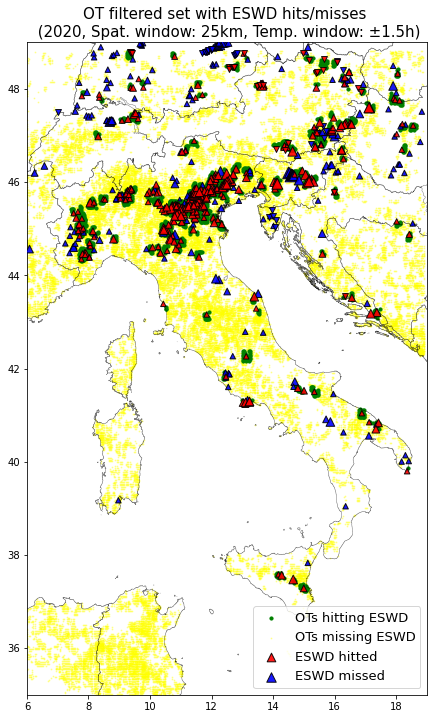

In [73]:
fig, ax = plt.subplots(figsize = (20,12))

plt.ylim(y_lim) #y_lim
plt.xlim(x_lim)  #x_lim

#OTs HITTING:
filt_OTset_land_HITTING_eswd_uniq_2020.plot(ax=ax, markersize=10, column='otpmax', color='green',
                                  zorder=2, label='OTs hitting ESWD')   

filt_OTset_land_MISSING_eswd_2020.plot(ax=ax, markersize=1, column='otpmax', color='yellow',
                                  zorder=1,alpha=0.3, label='OTs missing ESWD') 

#shapefiles    
for shp in sf_geo:
    shp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=3)

#ESWD REPORTS:

#HITTED
#divide dataset in subsets with info on size of hail or not:
filt_eswd_HITTED_uniq_2020_NOsize = filt_eswd_HITTED_uniq_2020.loc[np.isnan(filt_eswd_HITTED_uniq_2020['size']) == True].reset_index(drop=True)
filt_eswd_HITTED_uniq_2020_wsize = filt_eswd_HITTED_uniq_2020.loc[np.isnan(filt_eswd_HITTED_uniq_2020['size']) == False].reset_index(drop=True)
"""
pl.scatter(filt_eswd_HITTED_uniq_2020_wsize.lon, filt_eswd_HITTED_uniq_2020_wsize.lat, 
           15*filt_eswd_HITTED_uniq_2020_wsize['size'], c='red',marker="^", edgecolor='k',alpha=0.9, zorder=5, 
           label='ESWD hitted')
pl.scatter(filt_eswd_HITTED_uniq_2020_NOsize.lon, filt_eswd_HITTED_uniq_2020_NOsize.lat, 35,
                c='red',marker="v", edgecolor='k',alpha=0.9,zorder=5)
"""
#MISSED
#divide dataset in subsets with info on size of hail or not:
filt_eswd_MISSED_2020_NOsize = filt_eswd_MISSED_2020.loc[np.isnan(filt_eswd_MISSED_2020['size']) == True].reset_index(drop=True)
filt_eswd_MISSED_2020_wsize = filt_eswd_MISSED_2020.loc[np.isnan(filt_eswd_MISSED_2020['size']) == False].reset_index(drop=True)

pl.scatter(filt_eswd_MISSED_2020_wsize.lon, filt_eswd_MISSED_2020_wsize.lat, 15*filt_eswd_MISSED_2020_wsize['size'],
           c='blue',marker="^", edgecolor='k',alpha=0.9, zorder=4, label='ESWD missed') 
pl.scatter(filt_eswd_MISSED_2020_NOsize.lon, filt_eswd_MISSED_2020_NOsize.lat, 35,
           c='blue',marker="v", edgecolor='k',alpha=0.9, zorder=4)   


#cell.plot(ax=ax, facecolor="none", edgecolor='grey');
plt.title('OT filtered set with ESWD hits/misses \n (2020, Spat. window: 25km, Temp. window: ±1.5h)',
          fontsize=15);
plt.legend(loc='best', fontsize=13)

### 4.2) - Full period 2016-2020

In [ ]:
#read dictionaries for each year

with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2016/unfiltOTset_vs_eswd.txt', 'rb') as file:
     allOTset_valid_eswd_2016 = pickle.load(file)

with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2017/unfiltOTset_vs_eswd.txt', 'rb') as file:
     allOTset_valid_eswd_2017 = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2018/unfiltOTset_vs_eswd.txt', 'rb') as file:
     allOTset_valid_eswd_2018 = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2019/unfiltOTset_vs_eswd.txt', 'rb') as file:
     allOTset_valid_eswd_2019 = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2020/unfiltOTset_vs_eswd.txt', 'rb') as file:
     allOTset_valid_eswd_2020 = pickle.load(file)

In [30]:
#read dictionary from external file

with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2016/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2016 = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2017/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2017 = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2018/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2018 = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2019/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2019 = pickle.load(file)
        
with open(fold + 'data/OTfilter_validation/NewThresh_vsESWD_2016-2020/2020/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2020 = pickle.load(file)

In [36]:
all_OTset_land_HITTING_eswd_uniq_2016_2020 = pd.concat([allOTset_valid_eswd_2016['OT_HITTING_uniq'],
                                                        allOTset_valid_eswd_2017['OT_HITTING_uniq'],
                                                        allOTset_valid_eswd_2018['OT_HITTING_uniq'],
                                                        allOTset_valid_eswd_2019['OT_HITTING_uniq'],
                                                        allOTset_valid_eswd_2020['OT_HITTING_uniq']])

filt_OTset_land_HITTING_eswd_uniq_2016_2020 = pd.concat([filtOTset_valid_eswd_2016['OT_HITTING_uniq'],
                                                        filtOTset_valid_eswd_2017['OT_HITTING_uniq'],
                                                        filtOTset_valid_eswd_2018['OT_HITTING_uniq'],
                                                        filtOTset_valid_eswd_2019['OT_HITTING_uniq'],
                                                        filtOTset_valid_eswd_2020['OT_HITTING_uniq']])

In [37]:
all_eswd_HITTED_uniq_2016_2020 = pd.concat([allOTset_valid_eswd_2016['reports_HITTED_uniq'],
                                            allOTset_valid_eswd_2017['reports_HITTED_uniq'],
                                            allOTset_valid_eswd_2018['reports_HITTED_uniq'],
                                            allOTset_valid_eswd_2019['reports_HITTED_uniq'],
                                            allOTset_valid_eswd_2020['reports_HITTED_uniq']])

filt_eswd_HITTED_uniq_2016_2020 = pd.concat([filtOTset_valid_eswd_2016['reports_HITTED_uniq'],
                                            filtOTset_valid_eswd_2017['reports_HITTED_uniq'],
                                            filtOTset_valid_eswd_2018['reports_HITTED_uniq'],
                                            filtOTset_valid_eswd_2019['reports_HITTED_uniq'],
                                            filtOTset_valid_eswd_2020['reports_HITTED_uniq']])

In [43]:
all_eswd_HITTED_uniq_2016_2020

,datetime,lat,lon,size,QC_level,Time_accuracy,Max_hailst_weight,Thickness_hail_layer,Total_damage,N_injured,N_killed,Impacts,geometry
12,2016-05-01 15:00:00,41.933,9.333,NaN,QC1,3H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.33300 41.93300)
24,2016-05-10 16:43:00,47.400,7.083,1.5,QC1,15M,NaN,10.0,NaN,NaN,NaN,NaN,POINT (7.08300 47.40000)
25,2016-05-10 17:10:00,47.292,7.185,3.0,QC1,5M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (7.18500 47.29200)
33,2016-05-14 16:30:00,45.661,9.781,NaN,QC1,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.78100 45.66100)
35,2016-05-14 16:30:00,45.641,9.686,NaN,QC1,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (9.68600 45.64100)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,2020-09-25 14:00:00,45.949,12.494,5.0,QC1,5M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.49400 45.94900)
664,2020-09-25 15:23:00,45.946,13.621,4.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.62100 45.94600)
665,2020-09-25 19:00:00,43.391,10.433,2.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.43300 43.39100)
666,2020-09-25 20:30:00,40.701,17.339,4.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (17.33900 40.70100)
